## Topic-specific Modeling
Using combined news/tweet data from BuzzFeed, PolitiFact, GossipCop, COVID-19, Disasters. Unlike the FNID data, not all data has sources or titles. Also there are no dates included in this dataset. 

The goal in this notebook is to conduct binary classification to detect real/fake news on specific news topics (politics, gossip, COVID-19, disasters). We would like to see if for some events/topics, it's easier to identify false information (i.e., patterns in text are more apparent and easier to distinguish with modeling).

In [1]:
# general packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import re
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.stats import zscore
sns.set()

In [6]:
# import nlp packages
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# possible stop words
nltk_stop = set(stopwords.words('english'))
gensim_stop = set(STOPWORDS)

In [7]:
# load model preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

In [8]:
# load model packages
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

### Load Data
First we load the dataset. We had previously cleaned the data to conduct modeling on the full dataset and saved those results, so we load this data here. 

In [2]:
# load dataset - from first modeling file
tweet_data = pd.read_csv('tweet_data_modeling.csv', na_filter= False)

print(tweet_data.shape)
tweet_data.head()

(29052, 9)


Unnamed: 0        id                                              title  \
0           0  buzzfeed  Proof The Mainstream Media Is Manipulating The...   
1           1  buzzfeed  Charity: Clinton Foundation Distributed “Water...   
2           2  buzzfeed  A Hillary Clinton Administration May be Entire...   
3           3  buzzfeed  Trump’s Latest Campaign Promise May Be His Mos...   
4           4  buzzfeed                    Website is Down For Maintenance   

                                                text                 source  \
0  I woke up this morning to find a variation of ...  www.addictinginfo.org   
1  Former President Bill Clinton and his Clinton ...        eaglerising.com   
2  After collapsing just before trying to step in...        eaglerising.com   
3  Donald Trump is, well, deplorable. He’s sugges...  www.addictinginfo.org   
4                    Website is Down For Maintenance      www.proudcons.com   

  target                                         clean_text  \
0   fake  woke morning variation headline splashed news ...   
1   fake  president clinton clinton health access initia...   
2   fake  collapsing trying step van removed ceremony ne...   
3   fake  donald trump deplorable he suggested building ...   
4   fake                                website maintenance   

                                         clean_title  news_class  
0  proof mainstream medium manipulating election ...           0  
1  charity clinton foundation distributed watered...           0  
2  hillary clinton administration entirely run fi...           0  
3             trump latest campaign promise horrible           0  
4                                website maintenance           0

In [3]:
# check null data
tweet_data.isnull().sum()

Unnamed: 0     0
id             0
title          0
text           0
source         0
target         0
clean_text     0
clean_title    0
news_class     0
dtype: int64

In [4]:
# merge title and text
tweet_data['combined_text'] = tweet_data['clean_title'] + ' ' + tweet_data['clean_text']
tweet_data['combined_text'] = tweet_data["combined_text"].str.strip()
tweet_data['combined_text'] = tweet_data['combined_text'].str.replace('\n','')
tweet_data.head()

Unnamed: 0        id                                              title  \
0           0  buzzfeed  Proof The Mainstream Media Is Manipulating The...   
1           1  buzzfeed  Charity: Clinton Foundation Distributed “Water...   
2           2  buzzfeed  A Hillary Clinton Administration May be Entire...   
3           3  buzzfeed  Trump’s Latest Campaign Promise May Be His Mos...   
4           4  buzzfeed                    Website is Down For Maintenance   

                                                text                 source  \
0  I woke up this morning to find a variation of ...  www.addictinginfo.org   
1  Former President Bill Clinton and his Clinton ...        eaglerising.com   
2  After collapsing just before trying to step in...        eaglerising.com   
3  Donald Trump is, well, deplorable. He’s sugges...  www.addictinginfo.org   
4                    Website is Down For Maintenance      www.proudcons.com   

  target                                         clean_text  \
0   fake  woke morning variation headline splashed news ...   
1   fake  president clinton clinton health access initia...   
2   fake  collapsing trying step van removed ceremony ne...   
3   fake  donald trump deplorable he suggested building ...   
4   fake                                website maintenance   

                                         clean_title  news_class  \
0  proof mainstream medium manipulating election ...           0   
1  charity clinton foundation distributed watered...           0   
2  hillary clinton administration entirely run fi...           0   
3             trump latest campaign promise horrible           0   
4                                website maintenance           0   

                                       combined_text  
0  proof mainstream medium manipulating election ...  
1  charity clinton foundation distributed watered...  
2  hillary clinton administration entirely run fi...  
3  trump latest campaign promise horrible donald ...  
4            website maintenance website maintenance

In [5]:
# subset by topics
polit = tweet_data[tweet_data['id'].str.contains('polit')]
print(polit.shape)

gossip = tweet_data[tweet_data['id'].str.contains('gossip')]
print(gossip.shape)

covid = tweet_data[tweet_data['id'].str.contains('covid')]
print(covid.shape)

natural = tweet_data[tweet_data['id'].str.contains('natural')]
print(natural.shape)

(955, 10)
(19143, 10)
(1159, 10)
(7613, 10)


In [17]:
# create function to train and report metrics
def fit_model(model, X, y, cv=5, scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']):
    model.fit(X, y)
    preds = model.predict(X)
    print('Training Metrics: ')
    print(metrics.classification_report(y, preds))
    # cross validation
    cv_scores = cross_validate(model, X, y, scoring=scoring, cv=cv)
    print('Cross Validation (CV) Metrics:')
    print('Average CV Accuracy: ', cv_scores['test_accuracy'].mean())
    print('Average CV Precision: ', cv_scores['test_precision_macro'].mean())
    print('Average CV Recall: ', cv_scores['test_recall_macro'].mean())
    print('Average CV F1 Score: ', cv_scores['test_f1_macro'].mean())

# test metrics
def test_metrics(model, X, y, labels):
    preds = model.predict(X)
    print('Testing Metrics: ')
    print(metrics.classification_report(y, preds))
    
    # confusion matrix 
    cm = metrics.confusion_matrix(y, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # plot confusion matrix (normalized)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.heatmap(cm_norm, annot=True, cmap="Blues", annot_kws={"fontsize":10}, ax=ax[0])
    ax[0].set_xlabel('Predicted', fontsize=8)
    ax[0].set_ylabel('Actual', fontsize=8)
    ax[0].set_title('Normalized Confusion Matrix', fontsize=12, pad=12)
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)
    
    # roc curve 
    fpr, tpr, _ = metrics.roc_curve(y, preds)
    ax[1].plot(fpr, tpr)
    ax[1].plot([0,1], [0,1], linestyle='--')
    ax[1].set_xlabel('False Positive Rate', fontsize=8)
    ax[1].set_ylabel('True Positive Rate', fontsize=8)
    ax[1].set_title('ROC Curve', fontsize=12, pad=12)
    fig.tight_layout()

### Politics
First we see if we can predict real and fake news in the politics data subset. Similar to the exercise we did with the FNID dataset originally (since both were from PolitiFact)

<IPython.core.display.Javascript object>


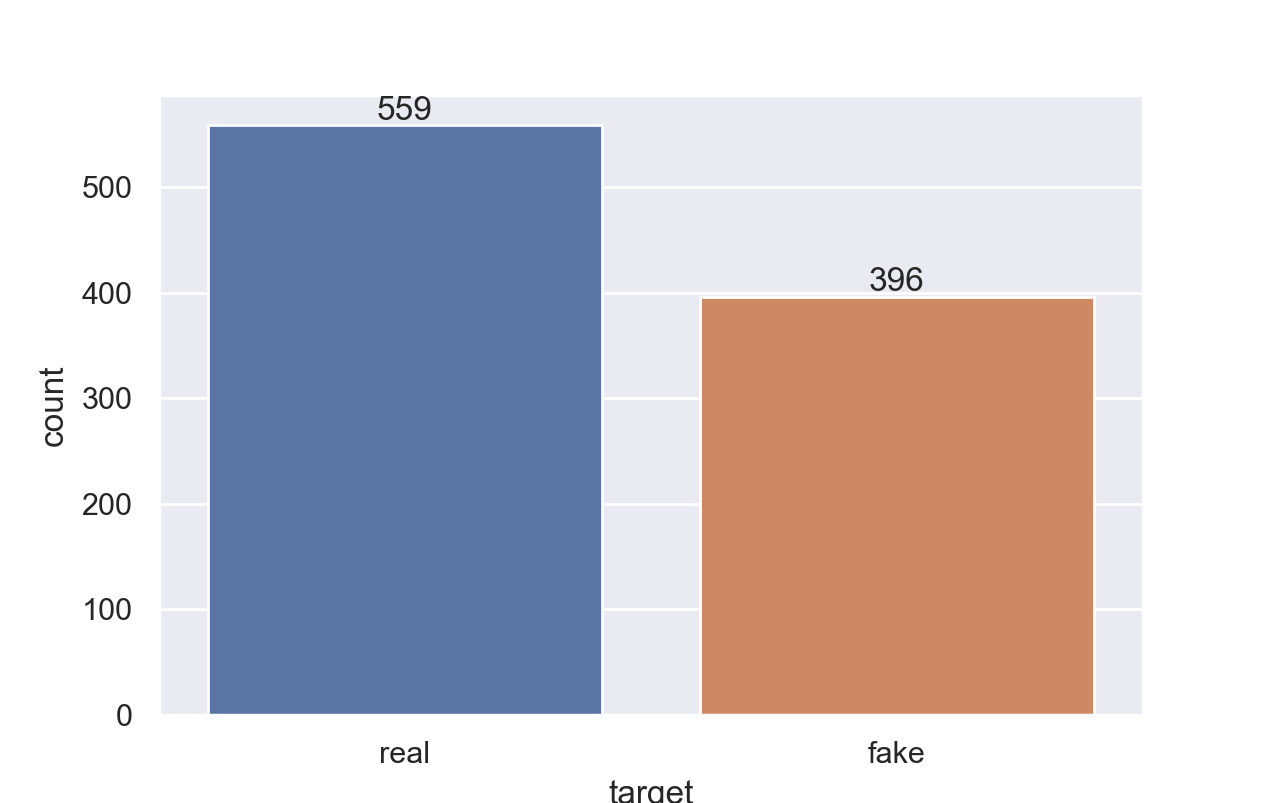

In [11]:
# check balance - make need to balance in modeling
ax=sns.countplot(x="target", data=polit)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

In [12]:
# balance data and run logistic, passive aggressive, Naive Bayes, rf, xgb
df_majority_pol = polit[polit.news_class==1]
df_minority_pol = polit[polit.news_class==0]

df_majority_downsampled_pol = resample(df_majority_pol, replace=False, n_samples=400, random_state=123)

df_balance_pol = pd.concat([df_majority_downsampled_pol, df_minority_pol])
df_balance_pol['news_class'].value_counts()

1    400
0    396
Name: news_class, dtype: int64

In [14]:
# X and y data
X_pol, y_pol = df_balance_pol['combined_text'].values.astype('str'), df_balance_pol['news_class']
X_pol[0]

'leonard lance claim federal tax code contains million word time long bible internal revenue code war peace read like novellathats onerous confounding nation tax code according rep leonard lance rth issued news release april calling meaningful tax reform blasting complexity tax codethe internal revenue code ballooned page millionword complicated mess seven time long bible good news lance said news releasebut news bad lancelet review size tax code compare size biblea report internal revenue service taxpayer advocate office tax code contained million word calculation downloading zipped file code unzipping running microsoft word wordcount feature according footnote report version report put number word code millionwe reached cch riverwoods illbased publisher twovolume winter version tax code told best estimate word length million cch wolters kluwer businessso lance claim number word generally accuratenext let look number page lance said based figure cited article washington post harvard b

In [15]:
# train/test split
trainX_pol, testX_pol, trainY_pol, testY_pol = train_test_split(X_pol,y_pol, train_size=0.8, random_state=42, shuffle=True)

In [16]:
print(trainX_pol.shape)
print(testY_pol.shape)

(636,)
(160,)


#### Logistic Regression

In [18]:
# fit general logistic model
pipe_lr_pol = Pipeline([('tfidf', TfidfVectorizer()), 
                    ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr_pol, trainX_pol, trainY_pol)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       311
           1       0.98      0.98      0.98       325

    accuracy                           0.98       636
   macro avg       0.98      0.98      0.98       636
weighted avg       0.98      0.98      0.98       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8475024606299213
Average CV Precision:  0.8506061542899195
Average CV Recall:  0.8482453030840128
Average CV F1 Score:  0.8472761644768655


In [20]:
# logistic regression - tune
lr_params_pol = {'tfidf__max_df': (0.70, 0.80, 0.90),
             'lr__penalty': ('l1','l2')}

lr_search_pol = RandomizedSearchCV(pipe_lr_pol, param_distributions=lr_params_pol,
                                   cv=3, random_state=42, return_train_score=True)
lr_search_pol.fit(trainX_pol, trainY_pol)

print("Best Hyperparameters:",lr_search_pol.best_params_)
print("Best CV score is {}".format(lr_search_pol.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.7, 'lr__penalty': 'l2'}
Best CV score is 0.8238993710691824


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        85
           1       0.85      0.88      0.86        75

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160



<IPython.core.display.Javascript object>


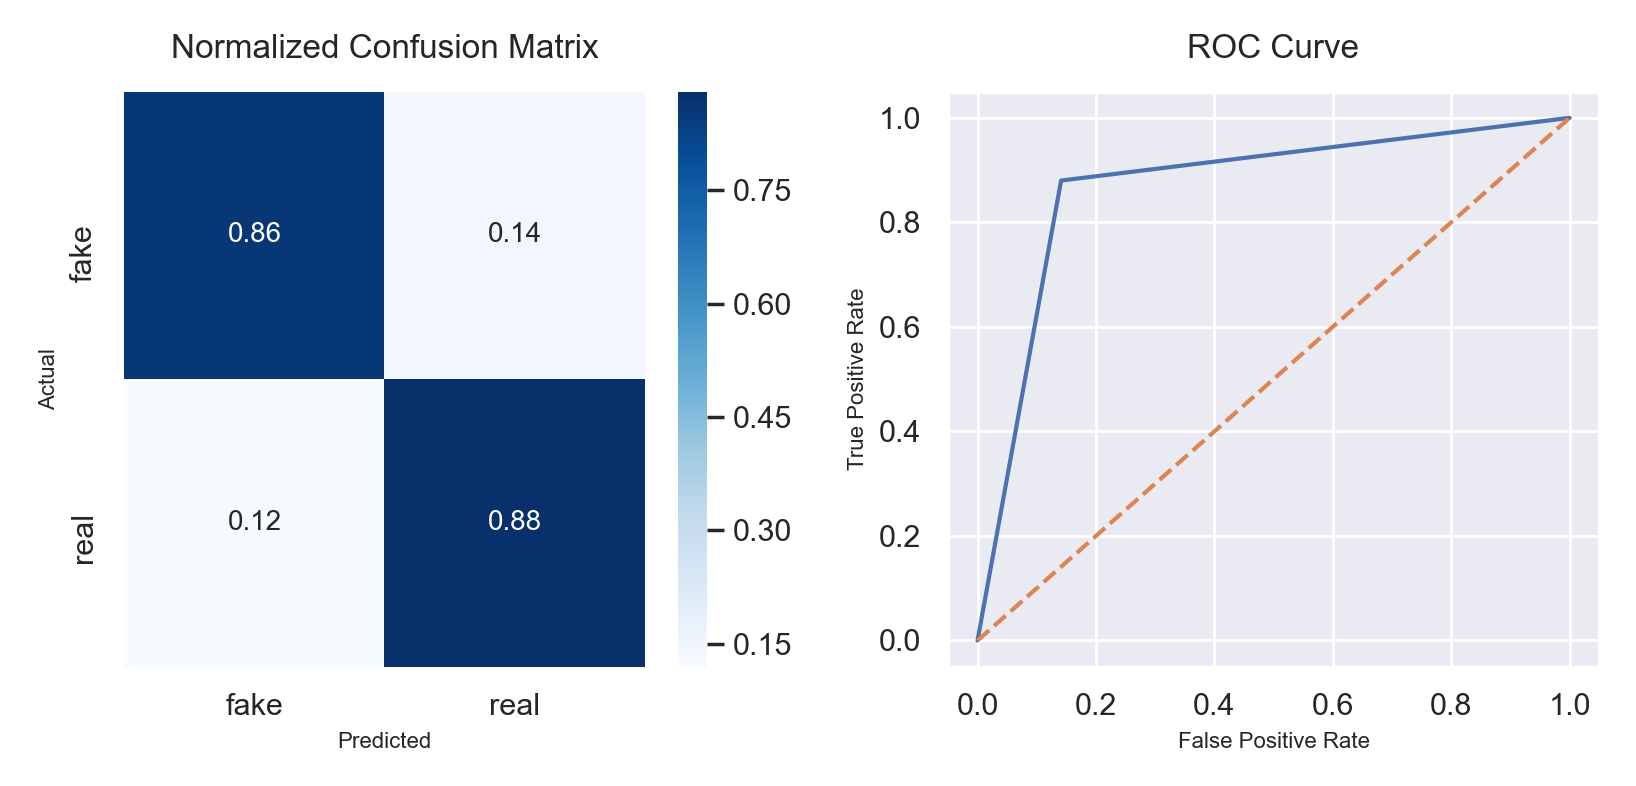

In [21]:
# test metrics logistitic regression
labels=['fake','real']
test_metrics(lr_search_pol.best_estimator_, testX_pol, testY_pol, labels)

In [33]:
# roc - lr
lr_pol_preds_test = lr_search_pol.best_estimator_.predict(testX_pol)
metrics.roc_auc_score(lr_pol_preds_test,testY_pol)

0.8681988742964354

In [22]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer_pol = TfidfVectorizer(max_df=0.7)
tfidf_train_pol = tfidf_vectorizer_pol.fit_transform(trainX_pol) 
tfidf_test_pol = tfidf_vectorizer_pol.transform(testX_pol)

#### Naive Bayes

In [23]:
# naive bayes classifier (multinomial)
nb_pol = MultinomialNB()
fit_model(nb_pol, tfidf_train_pol, trainY_pol)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       311
           1       0.92      1.00      0.96       325

    accuracy                           0.96       636
   macro avg       0.96      0.96      0.96       636
weighted avg       0.96      0.96      0.96       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7531742125984252
Average CV Precision:  0.7998309684054741
Average CV Recall:  0.7488845563039113
Average CV F1 Score:  0.7398360305963375


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.91      0.60      0.72        85
           1       0.67      0.93      0.78        75

    accuracy                           0.76       160
   macro avg       0.79      0.77      0.75       160
weighted avg       0.80      0.76      0.75       160



<IPython.core.display.Javascript object>


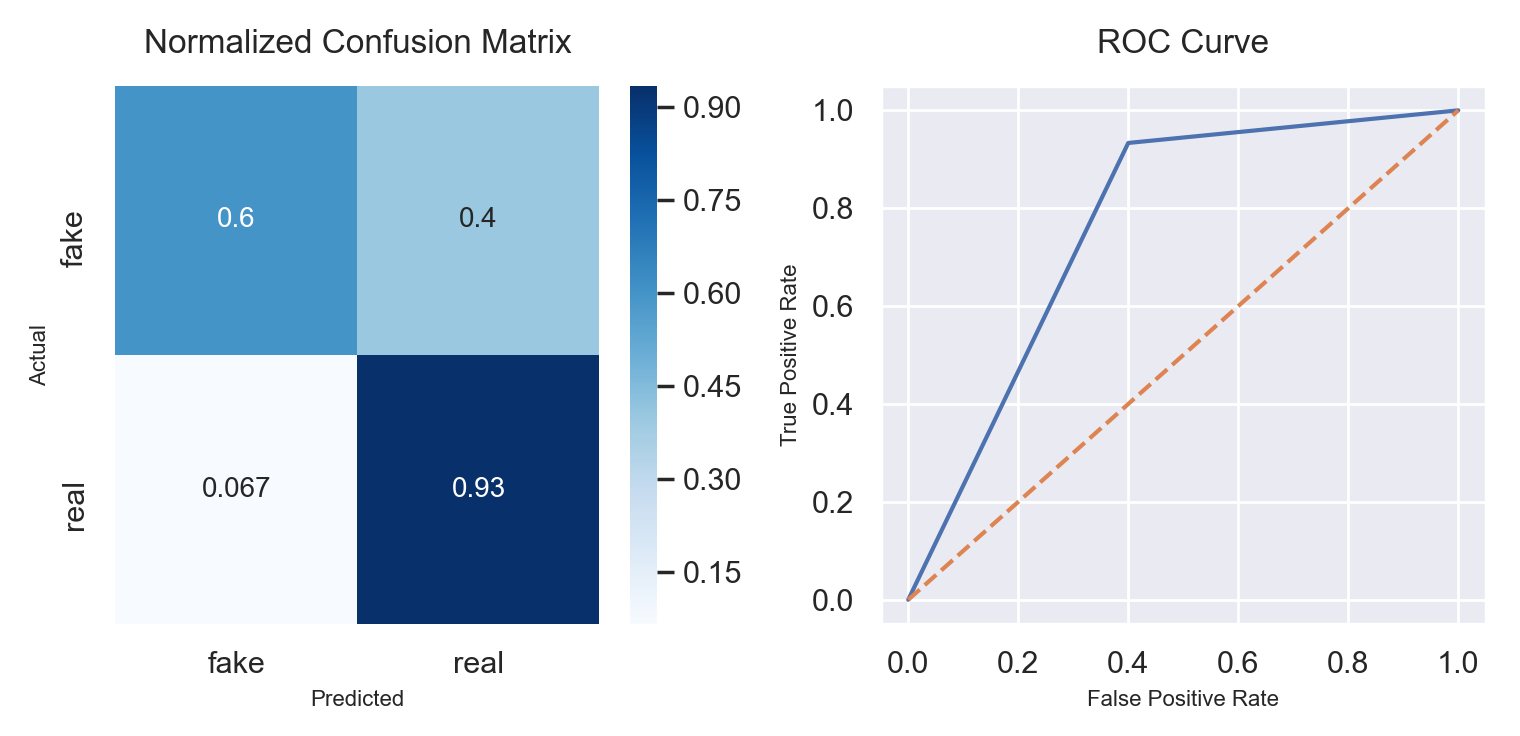

In [24]:
# NB - test metrics - politics
test_metrics(nb_pol, tfidf_test_pol, testY_pol, labels)

In [34]:
# roc - nb
nb_pol_preds_test = nb_pol.predict(tfidf_test_pol)
metrics.roc_auc_score(nb_pol_preds_test,testY_pol)

0.7918956043956045

#### Passive Agressive Classifier

In [25]:
# passive aggressive classifier 
pa_pol = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa_pol, tfidf_train_pol, trainY_pol)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       311
           1       1.00      0.99      1.00       325

    accuracy                           1.00       636
   macro avg       1.00      1.00      1.00       636
weighted avg       1.00      1.00      1.00       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.852177657480315
Average CV Precision:  0.8537804276816374
Average CV Recall:  0.8524884792626729
Average CV F1 Score:  0.8520340874865608


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        85
           1       0.86      0.89      0.88        75

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



<IPython.core.display.Javascript object>


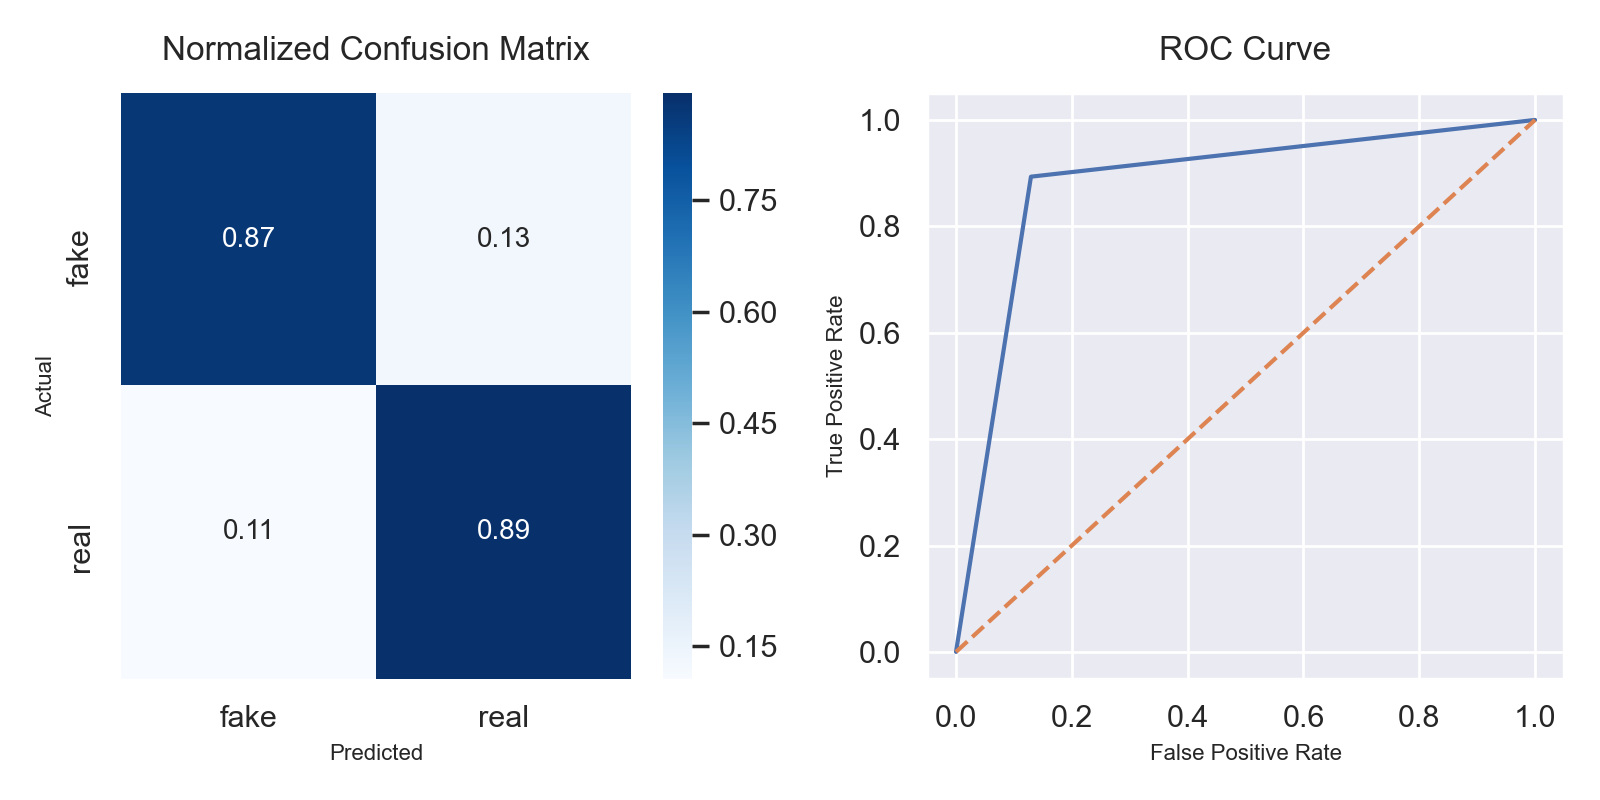

In [26]:
# PA - test metrics - politics
test_metrics(pa_pol, tfidf_test_pol, testY_pol, labels)

In [35]:
# roc - pa
pa_pol_preds_test = pa_pol.predict(tfidf_test_pol)
metrics.roc_auc_score(pa_pol_preds_test,testY_pol)

0.8807066916823015

#### Random Forest

In [27]:
# random forest classifier 
rf_pol = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model(rf_pol, tfidf_train_pol, trainY_pol, 3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       311
           1       1.00      1.00      1.00       325

    accuracy                           1.00       636
   macro avg       1.00      1.00      1.00       636
weighted avg       1.00      1.00      1.00       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8175330960796323
Average CV Precision:  0.8271056854279436
Average CV Recall:  0.8156469159148712
Average CV F1 Score:  0.8154266272125884


In [28]:
# RF - tune - took some time
rf_params_pol = {'n_estimators': [50, 75, 100, 200, 500], 
                  'max_features': ['auto', None]}

rf_search_pol = RandomizedSearchCV(rf_pol, param_distributions=rf_params_pol,
                                   cv=3, random_state=42, return_train_score=True)
rf_search_pol.fit(tfidf_train_pol, trainY_pol)

print("Best Hyperparameters:",rf_search_pol.best_params_)
print("Best CV score is {}".format(rf_search_pol.best_score_))

Best Hyperparameters: {'n_estimators': 500, 'max_features': 'auto'}
Best CV score is 0.8301886792452831


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        85
           1       0.78      0.89      0.83        75

    accuracy                           0.83       160
   macro avg       0.84      0.83      0.83       160
weighted avg       0.84      0.83      0.83       160



<IPython.core.display.Javascript object>


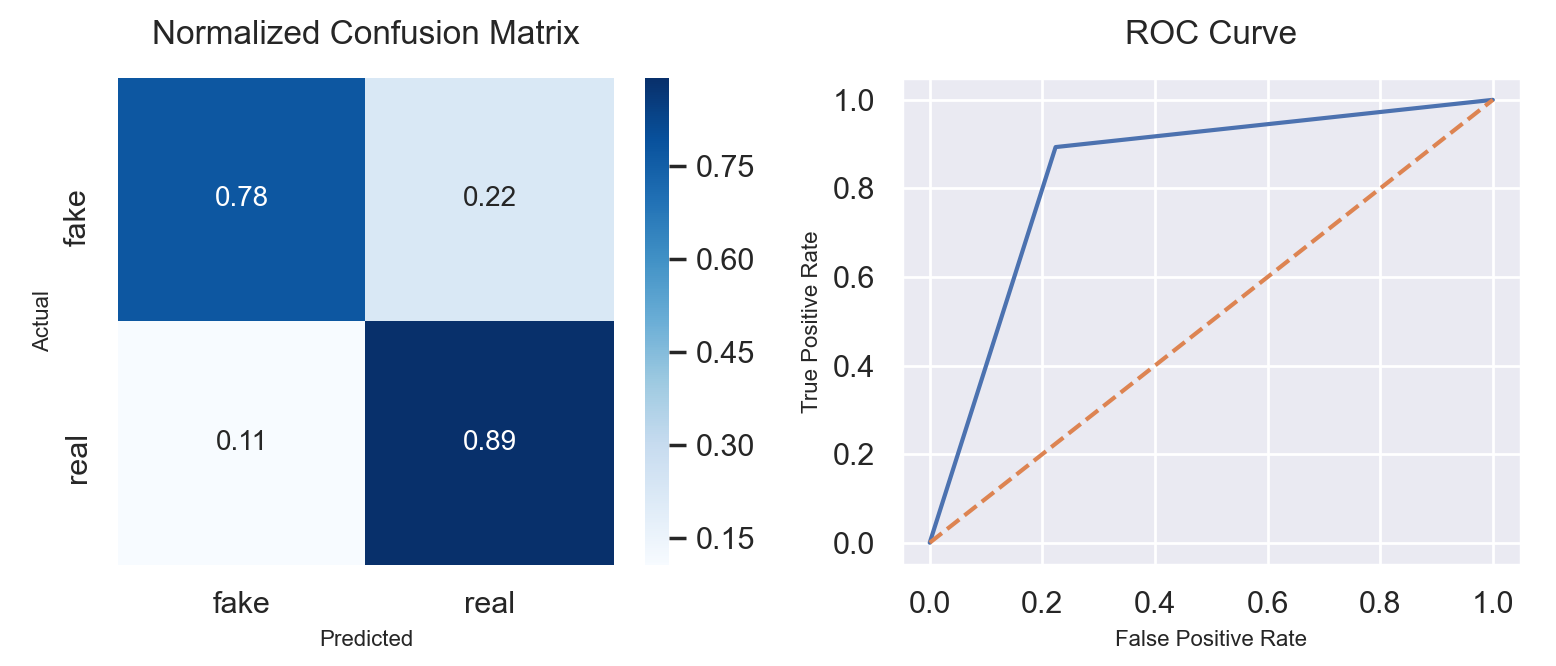

In [29]:
# test metrics RF
test_metrics(rf_search_pol.best_estimator_, tfidf_test_pol, testY_pol, labels)

In [36]:
# roc - rf
rf_pol_preds_test = rf_search_pol.best_estimator_.predict(tfidf_test_pol)
metrics.roc_auc_score(rf_pol_preds_test,testY_pol)

0.8354808296668762

#### Boosting
Gradient Boosting and XGBoost

In [30]:
# gradient boosting classifier 
gb_pol = GradientBoostingClassifier(random_state=42)
fit_model(gb_pol, tfidf_train_pol, trainY_pol,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       311
           1       0.96      1.00      0.98       325

    accuracy                           0.98       636
   macro avg       0.98      0.98      0.98       636
weighted avg       0.98      0.98      0.98       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8097530806666781
Average CV Precision:  0.8159126636573125
Average CV Recall:  0.8081826792282985
Average CV F1 Score:  0.8082001984339159


In [31]:
# xgb classifier 
xgb_pol = xgb.XGBClassifier(random_state=42)
fit_model(xgb_pol, tfidf_train_pol, trainY_pol,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       311
           1       0.97      1.00      0.98       325

    accuracy                           0.98       636
   macro avg       0.99      0.98      0.98       636
weighted avg       0.98      0.98      0.98       636

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8034488689167004
Average CV Precision:  0.8042461692461692
Average CV Recall:  0.803065617489922
Average CV F1 Score:  0.8031215757854969


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        85
           1       0.85      0.92      0.88        75

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



<IPython.core.display.Javascript object>


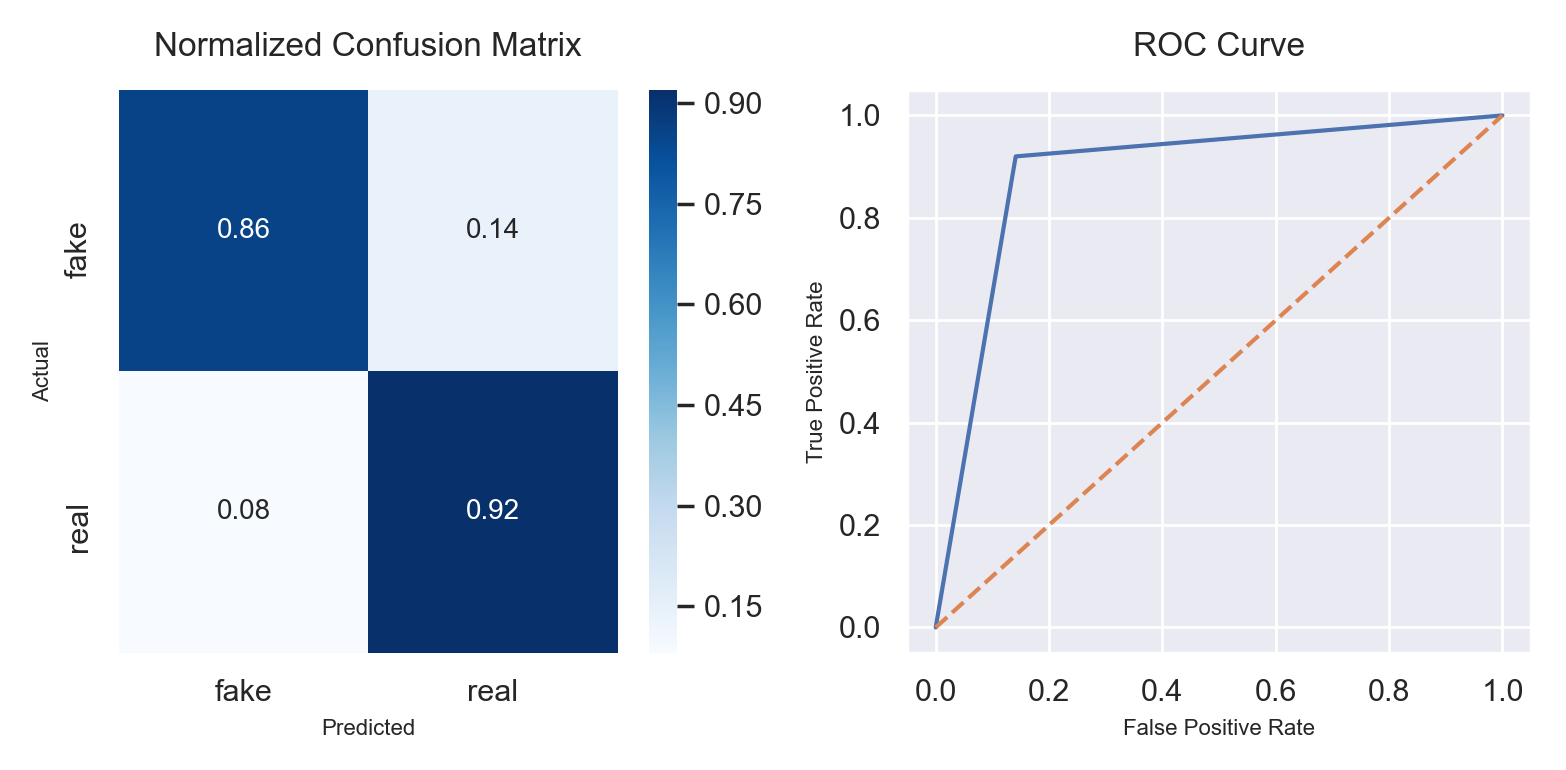

In [32]:
# test metric xgb
test_metrics(xgb_pol, tfidf_test_pol, testY_pol, labels)

In [37]:
# roc - xgb
xgb_pol_preds_test = xgb_pol.predict(tfidf_test_pol)
metrics.roc_auc_score(xgb_pol_preds_test,testY_pol)

0.8879512423816222

### Gossip
Next we will look at data from GossipCop - this data is highly imbalanced.

<IPython.core.display.Javascript object>


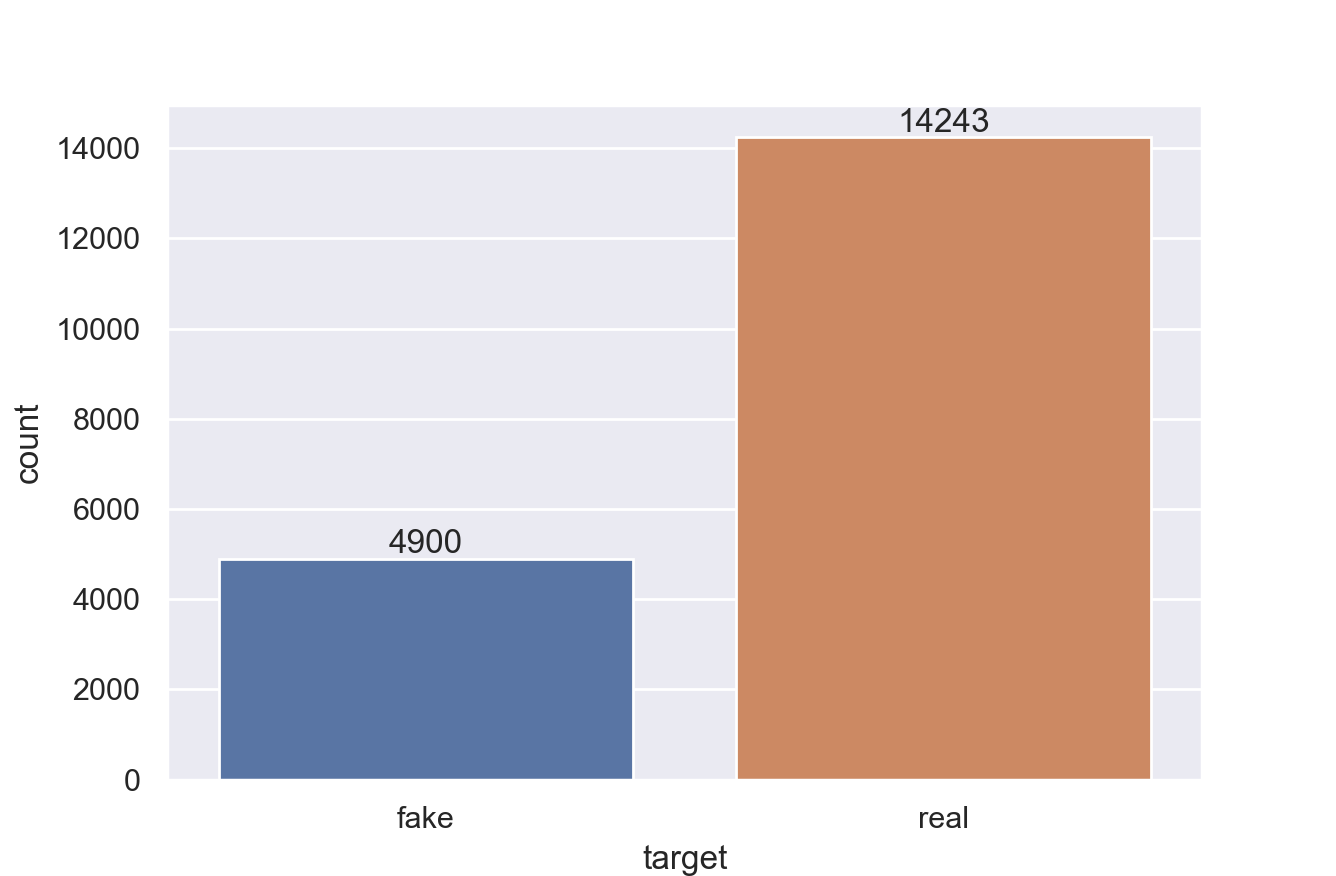

In [38]:
# check balance - make need to balance in modeling
ax=sns.countplot(x="target", data=gossip)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

In [39]:
# balance data and run logistic, passive aggressive, Naive Bayes, rf, xgb
df_majority_gos = gossip[gossip.news_class==1]
df_minority_gos = gossip[gossip.news_class==0]

df_majority_downsampled_gos = resample(df_majority_gos, replace=False, n_samples=5000, random_state=123)

df_balance_gos = pd.concat([df_majority_downsampled_gos, df_minority_gos])
df_balance_gos['news_class'].value_counts()

1    5000
0    4900
Name: news_class, dtype: int64

In [40]:
# X and y data
X_gos, y_gos = df_balance_gos['combined_text'].values.astype('str'), df_balance_gos['news_class']
X_gos[0]

'eniko parrish accepts kevin hart apology alleged extortion scandal twitter blasting kevin hart infidelity look like pregnant wife eniko parrish forgiven past indiscretionsaccording e news parrish pregnant hart childhas accepted husband apology plan forward coupleeniko aware whats going kevin perfect source told siteshe accepted apology focused pregnancy whats come plan divorce belief kevin good husband come home herthe source added bothered story way press people asking best ignore forward listens husband going stressed supporting standing himgirl like love itsince ride star gave public apology couple seen parrish rocking engagement ring unbothered lunch weekas previously reported comedian took social medium saturday publicly profusely sorry parrish kid heaven hart hendix hart previous marriage past bad behaviorim place life feel like target smart decision recently didnt said actori bad error judgement environment bad thing happen confessedand know going hurt people closest talked tom

In [42]:
# train/test split
trainX_gos, testX_gos, trainY_gos, testY_gos = train_test_split(X_gos,y_gos, train_size=0.8, random_state=42, shuffle=True)

In [43]:
print(trainX_gos.shape)
print(testY_gos.shape)

(7920,)
(1980,)


#### Logistic Regression

In [44]:
# fit general logistic model
pipe_lr_gos = Pipeline([('tfidf', TfidfVectorizer()), 
                    ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr_gos, trainX_gos, trainY_gos)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3928
           1       0.85      0.92      0.89      3992

    accuracy                           0.88      7920
   macro avg       0.88      0.88      0.88      7920
weighted avg       0.88      0.88      0.88      7920



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7986061049001727
Average CV Precision:  0.803798029690619
Average CV Recall:  0.7980743193993985
Average CV F1 Score:  0.7975353486482664


In [45]:
# logistic regression - tune - took some time
lr_params_gos = {'tfidf__max_df': (0.70, 0.80, 0.90),
             'lr__penalty': ('l1','l2')}

lr_search_gos = RandomizedSearchCV(pipe_lr_gos, param_distributions=lr_params_gos,
                                   cv=3, random_state=42, return_train_score=True)
lr_search_gos.fit(trainX_gos, trainY_gos)

print("Best Hyperparameters:",lr_search_gos.best_params_)
print("Best CV score is {}".format(lr_search_gos.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.7, 'lr__penalty': 'l2'}
Best CV score is 0.7986111111111112


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       972
           1       0.79      0.87      0.83      1008

    accuracy                           0.82      1980
   macro avg       0.82      0.82      0.82      1980
weighted avg       0.82      0.82      0.82      1980



<IPython.core.display.Javascript object>


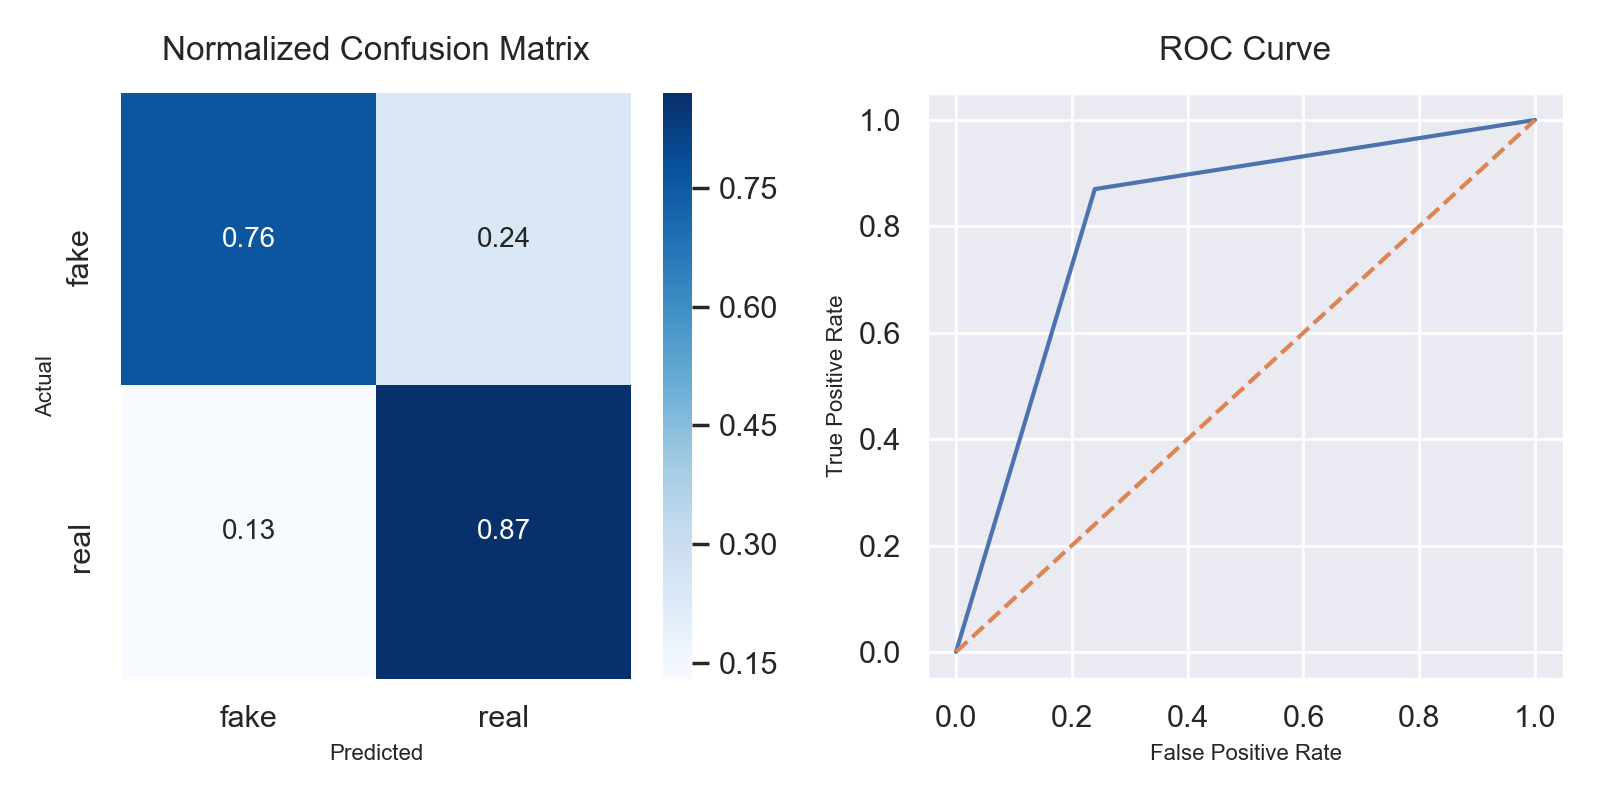

In [46]:
# test metrics logistitic regression
test_metrics(lr_search_gos.best_estimator_, testX_gos, testY_gos, labels)

In [47]:
# roc - lr
lr_gos_preds_test = lr_search_gos.best_estimator_.predict(testX_gos)
metrics.roc_auc_score(lr_gos_preds_test,testY_gos)

0.819757688723206

In [48]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer_gos = TfidfVectorizer(max_df=0.7)
tfidf_train_gos = tfidf_vectorizer_gos.fit_transform(trainX_gos) 
tfidf_test_gos = tfidf_vectorizer_gos.transform(testX_gos)

#### Naive Bayes

In [49]:
# naive bayes classifier (multinomial)
nb_gos = MultinomialNB()
fit_model(nb_gos, tfidf_train_gos, trainY_gos)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3928
           1       0.89      0.86      0.88      3992

    accuracy                           0.88      7920
   macro avg       0.88      0.88      0.88      7920
weighted avg       0.88      0.88      0.88      7920

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7896452030040123
Average CV Precision:  0.7912901716463926
Average CV Recall:  0.7899287388797398
Average CV F1 Score:  0.7894491666150742


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       972
           1       0.82      0.80      0.81      1008

    accuracy                           0.81      1980
   macro avg       0.81      0.81      0.81      1980
weighted avg       0.81      0.81      0.81      1980



<IPython.core.display.Javascript object>


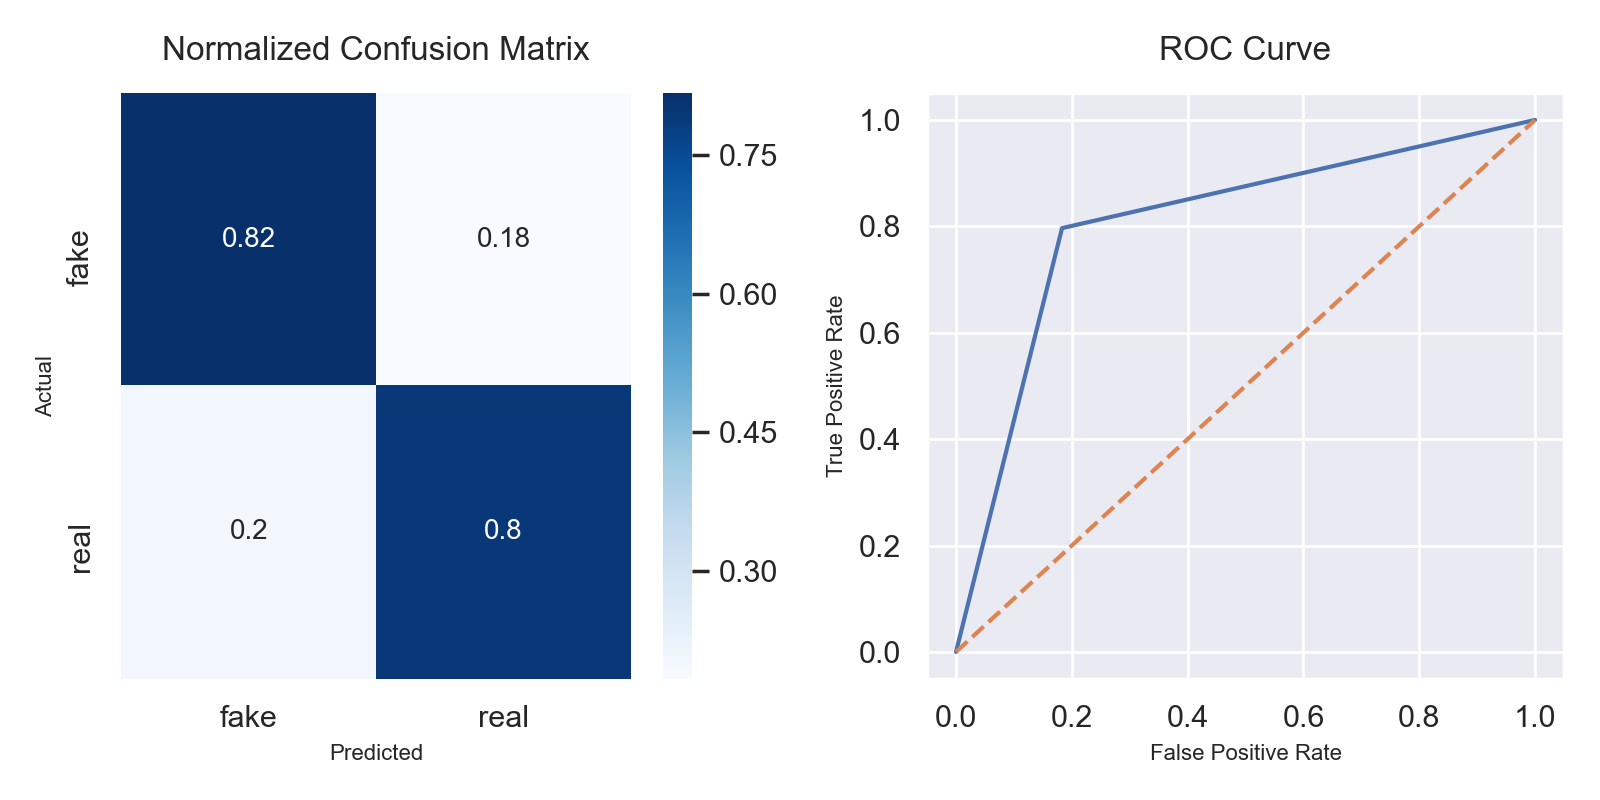

In [50]:
# NB - test metrics 
test_metrics(nb_gos, tfidf_test_gos, testY_gos, labels)

In [51]:
# roc - nb
nb_gos_preds_test = nb_gos.predict(tfidf_test_gos)
metrics.roc_auc_score(nb_gos_preds_test,testY_gos)

0.8066736461231874

#### Passive Agressive Classifier

In [52]:
# passive aggressive classifier 
pa_gos = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa_gos, tfidf_train_gos, trainY_gos)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3928
           1       0.99      0.99      0.99      3992

    accuracy                           0.99      7920
   macro avg       0.99      0.99      0.99      7920
weighted avg       0.99      0.99      0.99      7920

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.766915051813644
Average CV Precision:  0.7673728016722828
Average CV Recall:  0.7667708054470754
Average CV F1 Score:  0.7667431579755608


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       972
           1       0.79      0.79      0.79      1008

    accuracy                           0.79      1980
   macro avg       0.79      0.79      0.79      1980
weighted avg       0.79      0.79      0.79      1980



<IPython.core.display.Javascript object>


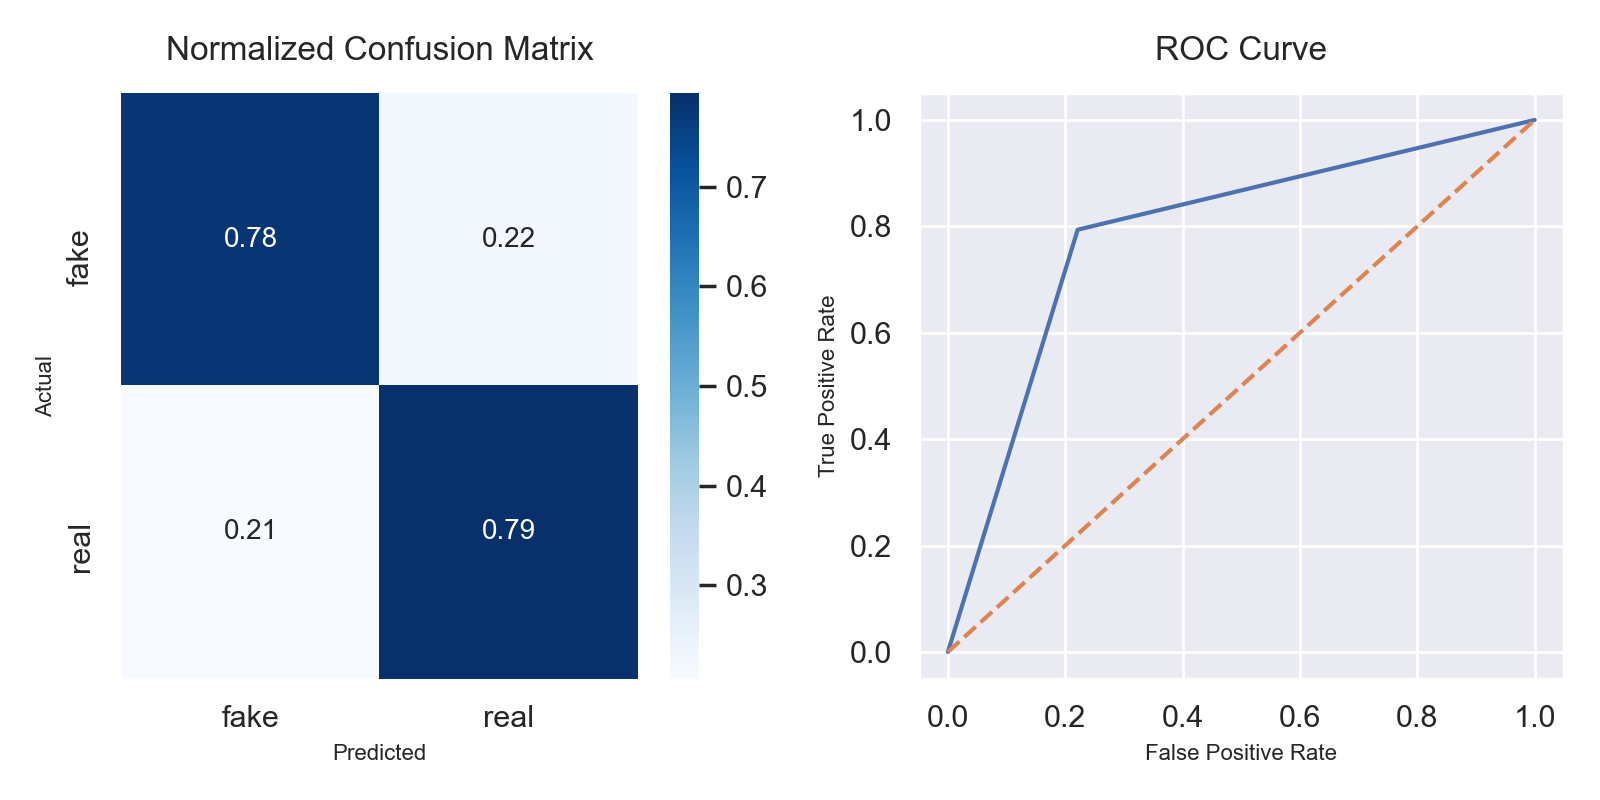

In [53]:
# PA - test metrics - gossip
test_metrics(pa_gos, tfidf_test_gos, testY_gos, labels)

In [54]:
# roc - pa
pa_gos_preds_test = pa_gos.predict(tfidf_test_gos)
metrics.roc_auc_score(pa_gos_preds_test,testY_gos)

0.7863166492253503

#### Random Forest

In [55]:
# random forest classifier 
rf_gos = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model(rf_gos, tfidf_train_gos, trainY_gos, 3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3928
           1       1.00      1.00      1.00      3992

    accuracy                           1.00      7920
   macro avg       1.00      1.00      1.00      7920
weighted avg       1.00      1.00      1.00      7920

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7848477946938561
Average CV Precision:  0.7881587327917065
Average CV Recall:  0.7844058543988015
Average CV F1 Score:  0.7840385751115196


In [56]:
# RF - CV/tune took some time - so just test on larger n_estimators, 
rf_gos_500 = RandomForestClassifier(n_estimators=500, random_state=42)
rf_gos_500.fit(tfidf_train_gos, trainY_gos)
rf_gos_500_tr_preds = rf_gos_500.predict(tfidf_train_gos)
print('Training Metrics: ')
print(metrics.classification_report(trainY_gos, rf_gos_500_tr_preds))

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3928
           1       1.00      1.00      1.00      3992

    accuracy                           1.00      7920
   macro avg       1.00      1.00      1.00      7920
weighted avg       1.00      1.00      1.00      7920



Testing Metrics: 
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       972
           1       0.77      0.85      0.81      1008

    accuracy                           0.80      1980
   macro avg       0.80      0.79      0.79      1980
weighted avg       0.80      0.80      0.80      1980



<IPython.core.display.Javascript object>


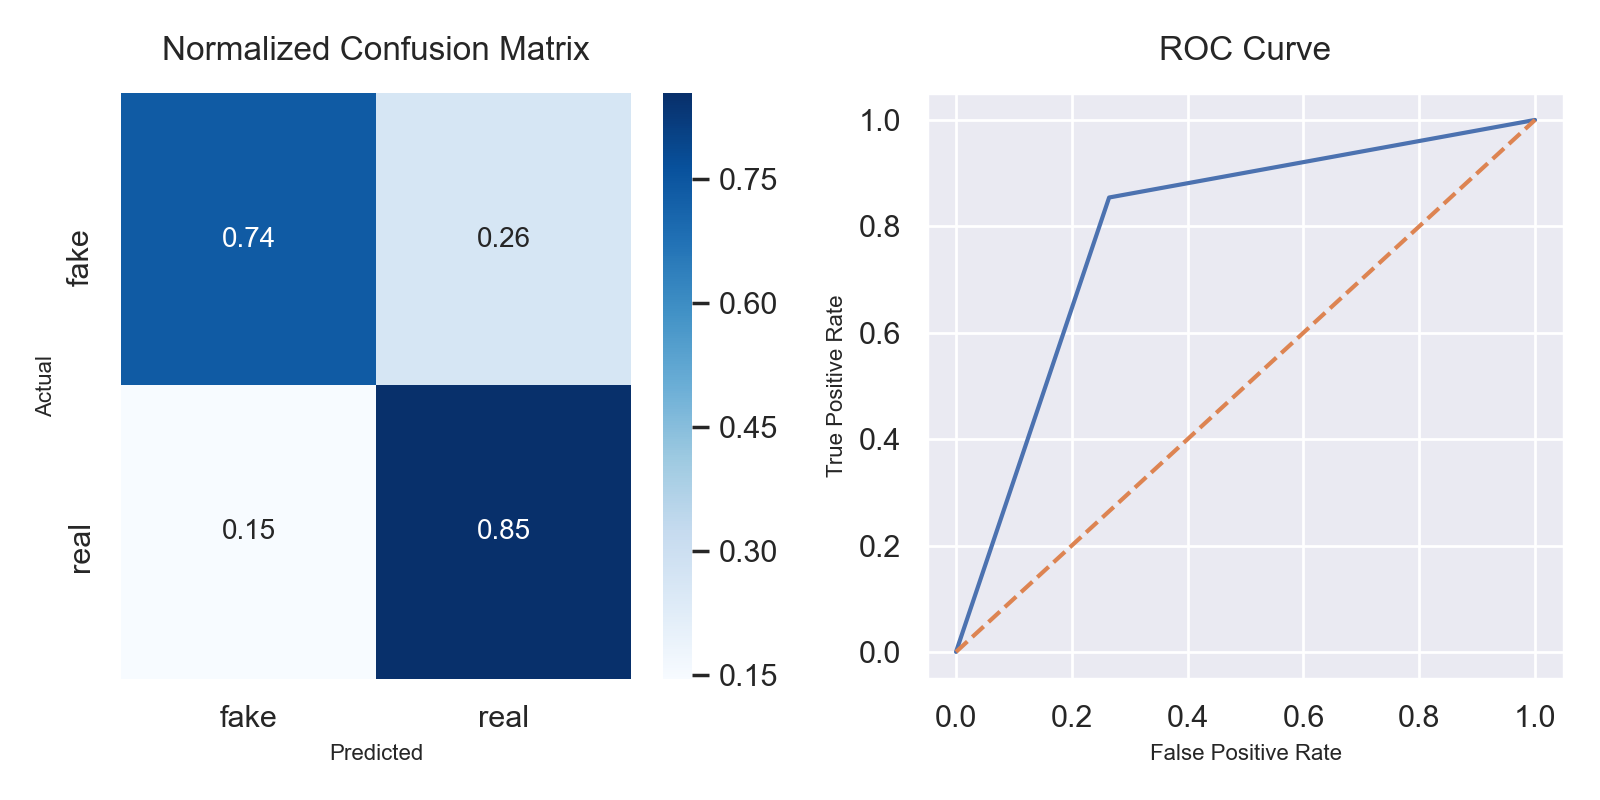

In [57]:
# test metrics RF_100
test_metrics(rf_gos, tfidf_test_gos, testY_gos, labels)

Testing Metrics: 
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       972
           1       0.78      0.86      0.82      1008

    accuracy                           0.80      1980
   macro avg       0.81      0.80      0.80      1980
weighted avg       0.81      0.80      0.80      1980



<IPython.core.display.Javascript object>


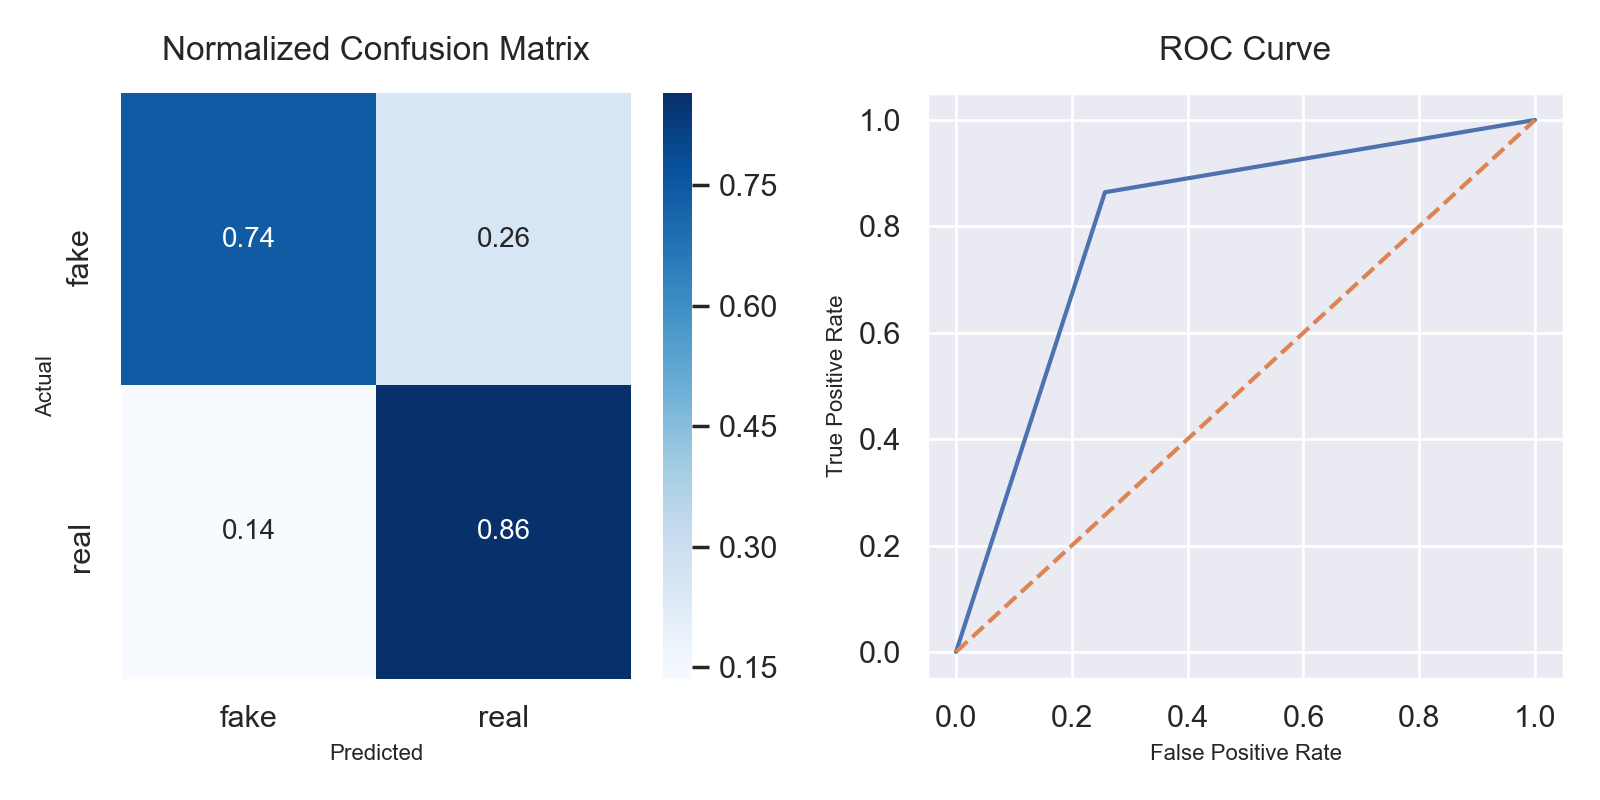

In [58]:
# test metrics RF_500 - no really difference
test_metrics(rf_gos_500, tfidf_test_gos, testY_gos, labels)

In [59]:
# roc - rf_500
rf_gos_preds_test = rf_gos_500.predict(tfidf_test_gos)
metrics.roc_auc_score(rf_gos_preds_test,testY_gos)

0.8087485292422469

#### Boosting
Gradient Boosting and XGBoost

In [60]:
# gradient boosting classifier - took some time to train/CV
gb_gos = GradientBoostingClassifier(random_state=42)
fit_model(gb_gos, tfidf_train_gos, trainY_gos,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3928
           1       0.76      0.91      0.83      3992

    accuracy                           0.81      7920
   macro avg       0.83      0.81      0.81      7920
weighted avg       0.83      0.81      0.81      7920

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7599749158104471
Average CV Precision:  0.7718526650367261
Average CV Recall:  0.7591201415868453
Average CV F1 Score:  0.7569091695188789


In [61]:
# xgb classifier
xgb_gos = xgb.XGBClassifier(random_state=42)
fit_model(xgb_gos, tfidf_train_gos, trainY_gos,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3928
           1       0.94      0.99      0.96      3992

    accuracy                           0.96      7920
   macro avg       0.96      0.96      0.96      7920
weighted avg       0.96      0.96      0.96      7920

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.775251642812585
Average CV Precision:  0.7783414327965373
Average CV Recall:  0.7748140568519902
Average CV F1 Score:  0.7744284201557671


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.73      0.78       972
           1       0.77      0.85      0.81      1008

    accuracy                           0.79      1980
   macro avg       0.80      0.79      0.79      1980
weighted avg       0.79      0.79      0.79      1980



<IPython.core.display.Javascript object>


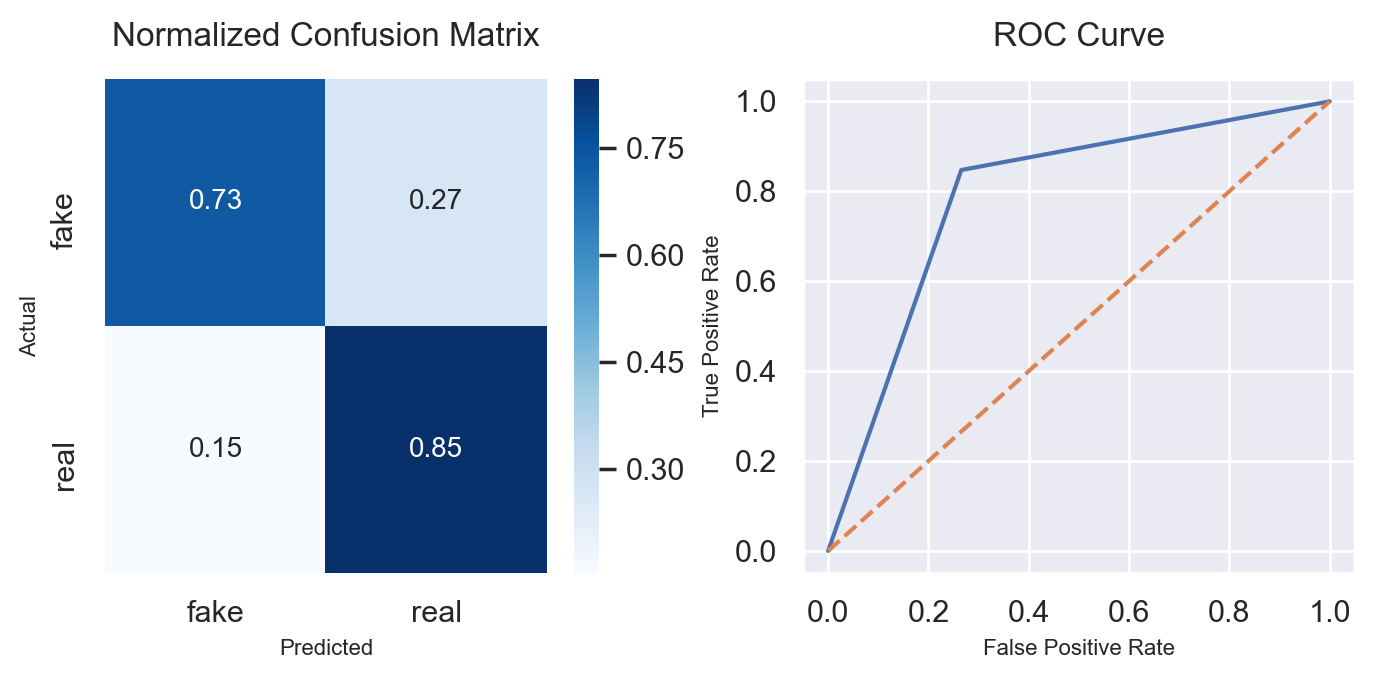

In [62]:
# test metric xgb
test_metrics(xgb_gos, tfidf_test_gos, testY_gos, labels)

In [63]:
# roc - xgb
xgb_gos_preds_test = xgb_gos.predict(tfidf_test_gos)
metrics.roc_auc_score(xgb_gos_preds_test,testY_gos)

0.7952831283360406

### COVID-19
Since this a recent news event, reporting generally limited to 2020, this is a pretty small dataset but we thought we could start modeling, with the option of adding more data over time to refine it.

<IPython.core.display.Javascript object>


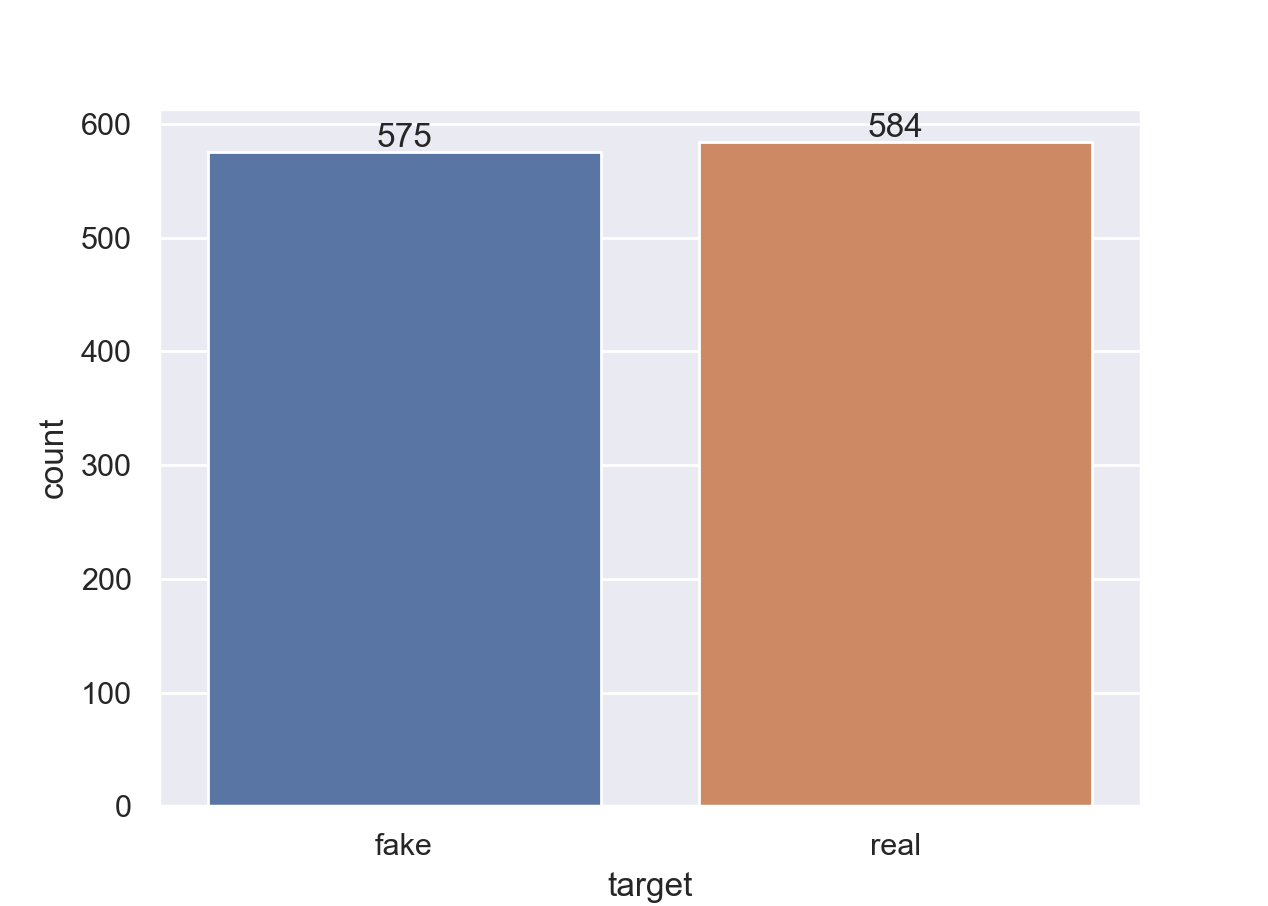

In [64]:
# check balance - pretty balanced 
ax=sns.countplot(x="target", data=covid)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

In [65]:
# X and y data
X_covid, y_covid = covid['combined_text'].values.astype('str'), covid['news_class']
X_covid[0]

'recent outbreak coronavirus covid world health organization giving away vaccine kit pay shipping need add water drug vaccine ready administered part kit hold pellet containing chemical machinery synthesis end product hold pellet containing instruction telll drug compound create mix part chosen combination add water treatment ready'

In [66]:
# train/test split
trainX_covid, testX_covid, trainY_covid, testY_covid = train_test_split(X_covid,y_covid, train_size=0.8, random_state=42, shuffle=True)

In [67]:
print(trainX_covid.shape)
print(testY_covid.shape)

(927,)
(232,)


#### Logistic Regression

In [68]:
# fit general logistic model
pipe_lr_covid = Pipeline([('tfidf', TfidfVectorizer()), 
                    ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr_covid, trainX_covid, trainY_covid)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       464
           1       0.98      0.96      0.97       463

    accuracy                           0.97       927
   macro avg       0.97      0.97      0.97       927
weighted avg       0.97      0.97      0.97       927



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation (CV) Metrics:
Average CV Accuracy:  0.89860391948751
Average CV Precision:  0.9000389994285427
Average CV Recall:  0.898574100046751
Average CV F1 Score:  0.8985070925729108


In [69]:
# logistic regression - tune
lr_params_covid = {'tfidf__max_df': (0.70, 0.80, 0.90),
             'lr__penalty': ('l1','l2')}

lr_search_covid = RandomizedSearchCV(pipe_lr_covid, param_distributions=lr_params_covid,
                                   cv=3, random_state=42, return_train_score=True)
lr_search_covid.fit(trainX_covid, trainY_covid)

print("Best Hyperparameters:",lr_search_covid.best_params_)
print("Best CV score is {}".format(lr_search_covid.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.7, 'lr__penalty': 'l2'}
Best CV score is 0.8856526429341963


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       111
           1       0.93      0.92      0.92       121

    accuracy                           0.92       232
   macro avg       0.92      0.92      0.92       232
weighted avg       0.92      0.92      0.92       232



<IPython.core.display.Javascript object>


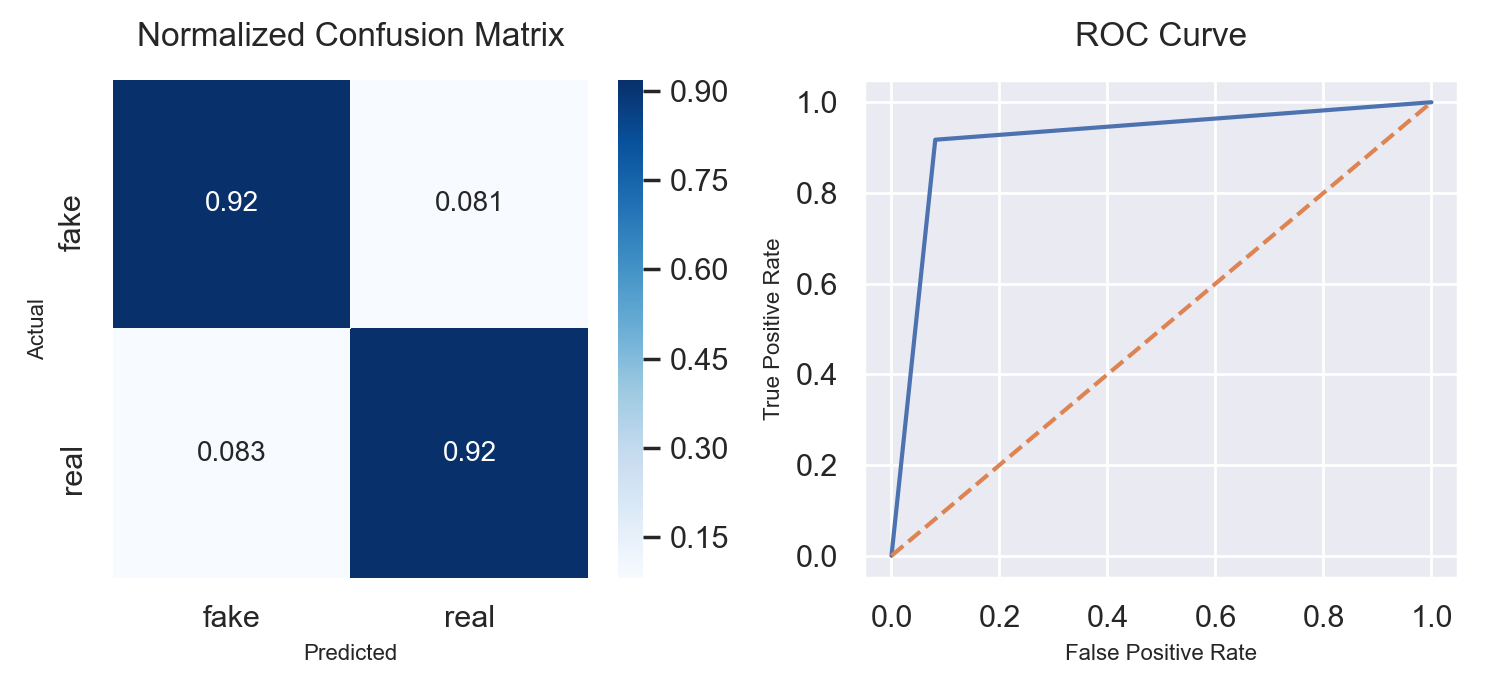

In [70]:
# test metrics logistitic regression
test_metrics(lr_search_covid.best_estimator_, testX_covid, testY_covid, labels)

In [71]:
# roc - lr
lr_covid_preds_test = lr_search_covid.best_estimator_.predict(testX_covid)
metrics.roc_auc_score(lr_covid_preds_test,testY_covid)

0.9178571428571429

In [72]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer_covid = TfidfVectorizer(max_df=0.7)
tfidf_train_covid = tfidf_vectorizer_covid.fit_transform(trainX_covid) 
tfidf_test_covid = tfidf_vectorizer_covid.transform(testX_covid)

#### Naive Bayes

In [73]:
# naive bayes classifier (multinomial)
nb_covid = MultinomialNB()
fit_model(nb_covid, tfidf_train_covid, trainY_covid)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       464
           1       0.95      0.95      0.95       463

    accuracy                           0.95       927
   macro avg       0.95      0.95      0.95       927
weighted avg       0.95      0.95      0.95       927

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8727041557686718
Average CV Precision:  0.8750639977733249
Average CV Recall:  0.8726507713884992
Average CV F1 Score:  0.8724784851127338


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       111
           1       0.89      0.90      0.90       121

    accuracy                           0.89       232
   macro avg       0.89      0.89      0.89       232
weighted avg       0.89      0.89      0.89       232



<IPython.core.display.Javascript object>


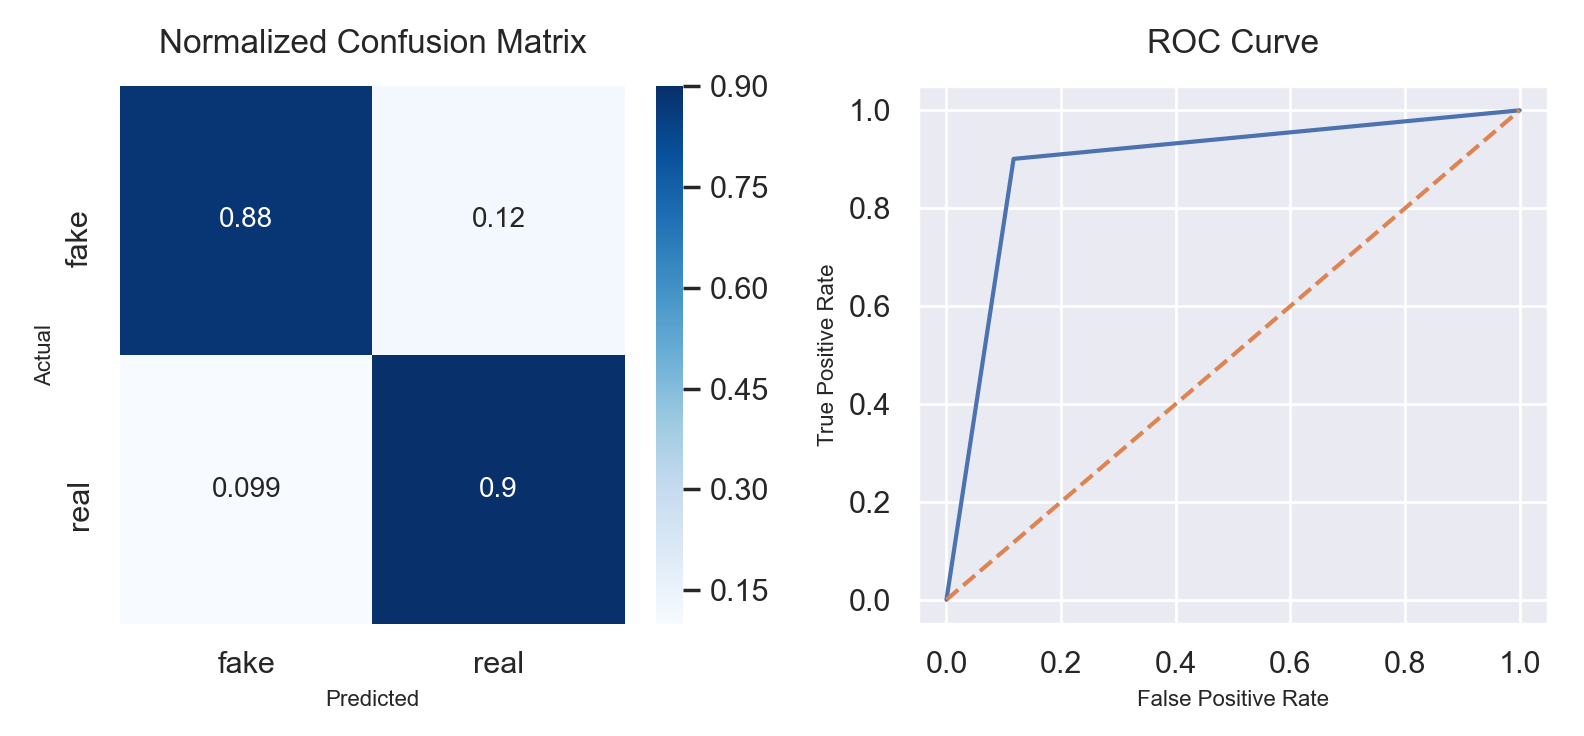

In [74]:
# NB - test metrics - covid
test_metrics(nb_covid, tfidf_test_covid, testY_covid, labels)

In [75]:
# roc - nb
nb_covid_preds_test = nb_covid.predict(tfidf_test_covid)
metrics.roc_auc_score(nb_covid_preds_test,testY_covid)

0.8921758569299553

#### Passive Agressive Classifier

In [76]:
# passive aggressive classifier 
pa_covid = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa_covid, tfidf_train_covid, trainY_covid)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       1.00      1.00      1.00       463

    accuracy                           1.00       927
   macro avg       1.00      1.00      1.00       927
weighted avg       1.00      1.00      1.00       927

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.9169769278394805
Average CV Precision:  0.9171291167245794
Average CV Recall:  0.9169705469845721
Average CV F1 Score:  0.9169685852389957


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       111
           1       0.94      0.93      0.94       121

    accuracy                           0.94       232
   macro avg       0.94      0.94      0.94       232
weighted avg       0.94      0.94      0.94       232



<IPython.core.display.Javascript object>


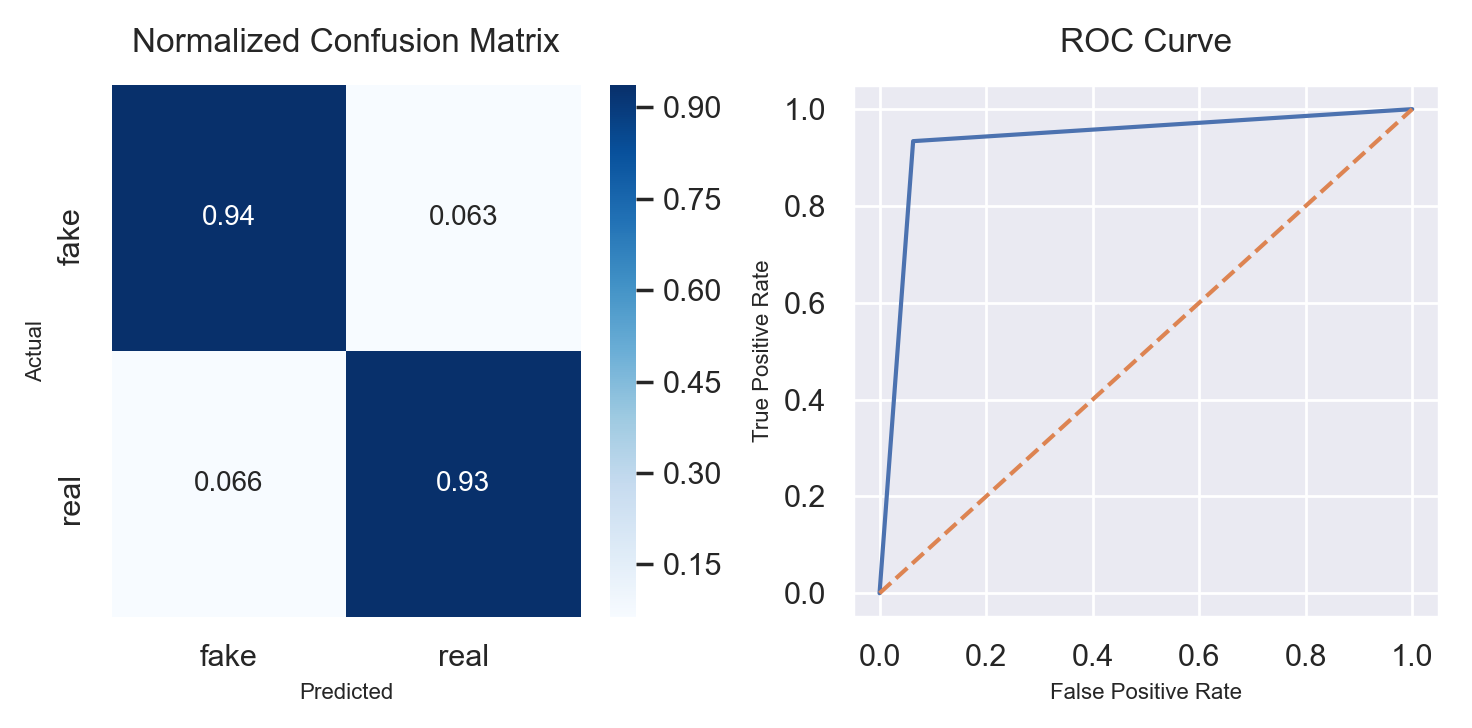

In [77]:
# PA - test metrics - covid
test_metrics(pa_covid, tfidf_test_covid, testY_covid, labels)

In [78]:
# roc - pa
pa_covid_preds_test = pa_covid.predict(tfidf_test_covid)
metrics.roc_auc_score(pa_covid_preds_test,testY_covid)

0.9351190476190476

#### Random Forest

In [79]:
# random forest classifier 
rf_covid = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model(rf_covid, tfidf_train_covid, trainY_covid, 3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       1.00      1.00      1.00       463

    accuracy                           1.00       927
   macro avg       1.00      1.00      1.00       927
weighted avg       1.00      1.00      1.00       927

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8802126449949813
Average CV Precision:  0.8813878894000599
Average CV Recall:  0.8802192431224688
Average CV F1 Score:  0.8801142202254549


In [80]:
# RF - tune - took some time
rf_params_covid = {'n_estimators': [50, 75, 100, 200, 500], 
                  'max_features': ['auto', None]}

rf_search_covid = RandomizedSearchCV(rf_covid, param_distributions=rf_params_covid,
                                   cv=3, random_state=42, return_train_score=True)
rf_search_covid.fit(tfidf_train_covid, trainY_covid)

print("Best Hyperparameters:",rf_search_covid.best_params_)
print("Best CV score is {}".format(rf_search_covid.best_score_))

Best Hyperparameters: {'n_estimators': 500, 'max_features': 'auto'}
Best CV score is 0.8921251348435815


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       111
           1       0.92      0.89      0.90       121

    accuracy                           0.90       232
   macro avg       0.90      0.90      0.90       232
weighted avg       0.90      0.90      0.90       232



<IPython.core.display.Javascript object>


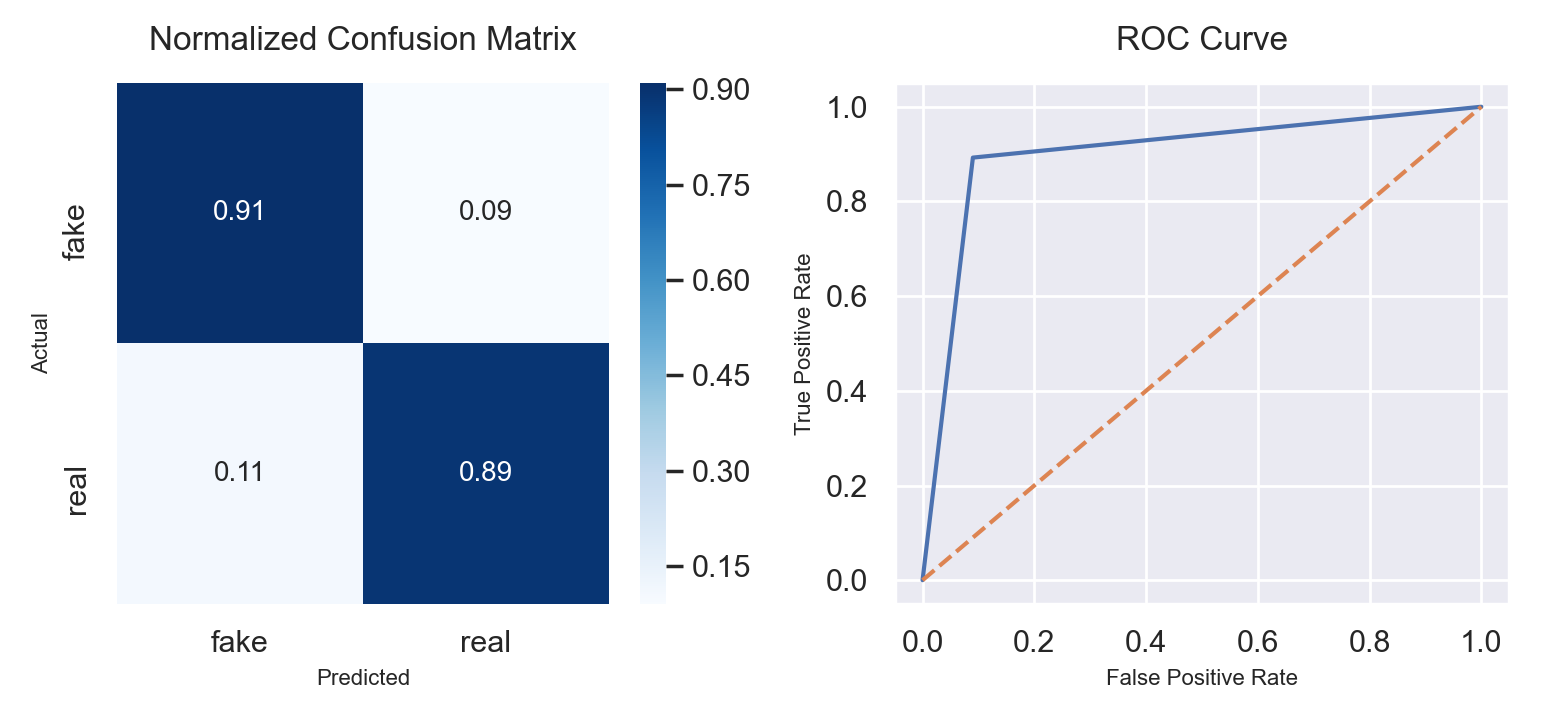

In [81]:
# test metrics RF
test_metrics(rf_search_covid.best_estimator_, tfidf_test_covid, testY_covid, labels)

In [82]:
# roc - rf
rf_covid_preds_test = rf_search_covid.best_estimator_.predict(tfidf_test_covid)
metrics.roc_auc_score(rf_covid_preds_test,testY_covid)

0.9006095747844186

#### Boosting
Gradient Boosting and XGBoost

In [83]:
# gradient boosting classifier 
gb_covid = GradientBoostingClassifier(random_state=42)
fit_model(gb_covid, tfidf_train_covid, trainY_covid,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       464
           1       1.00      0.99      0.99       463

    accuracy                           0.99       927
   macro avg       0.99      0.99      0.99       927
weighted avg       0.99      0.99      0.99       927

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8640836805258979
Average CV Precision:  0.8654691739970409
Average CV Recall:  0.8640622818042174
Average CV F1 Score:  0.8639496860821573


In [84]:
# xgb classifier 
xgb_covid = xgb.XGBClassifier(random_state=42)
fit_model(xgb_covid, tfidf_train_covid, trainY_covid,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       1.00      1.00      1.00       463

    accuracy                           1.00       927
   macro avg       1.00      1.00      1.00       927
weighted avg       1.00      1.00      1.00       927

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.8641220490891647
Average CV Precision:  0.8648852596651793
Average CV Recall:  0.8641251221896383
Average CV F1 Score:  0.8640506755071805


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       111
           1       0.89      0.83      0.86       121

    accuracy                           0.86       232
   macro avg       0.86      0.86      0.86       232
weighted avg       0.86      0.86      0.86       232



<IPython.core.display.Javascript object>


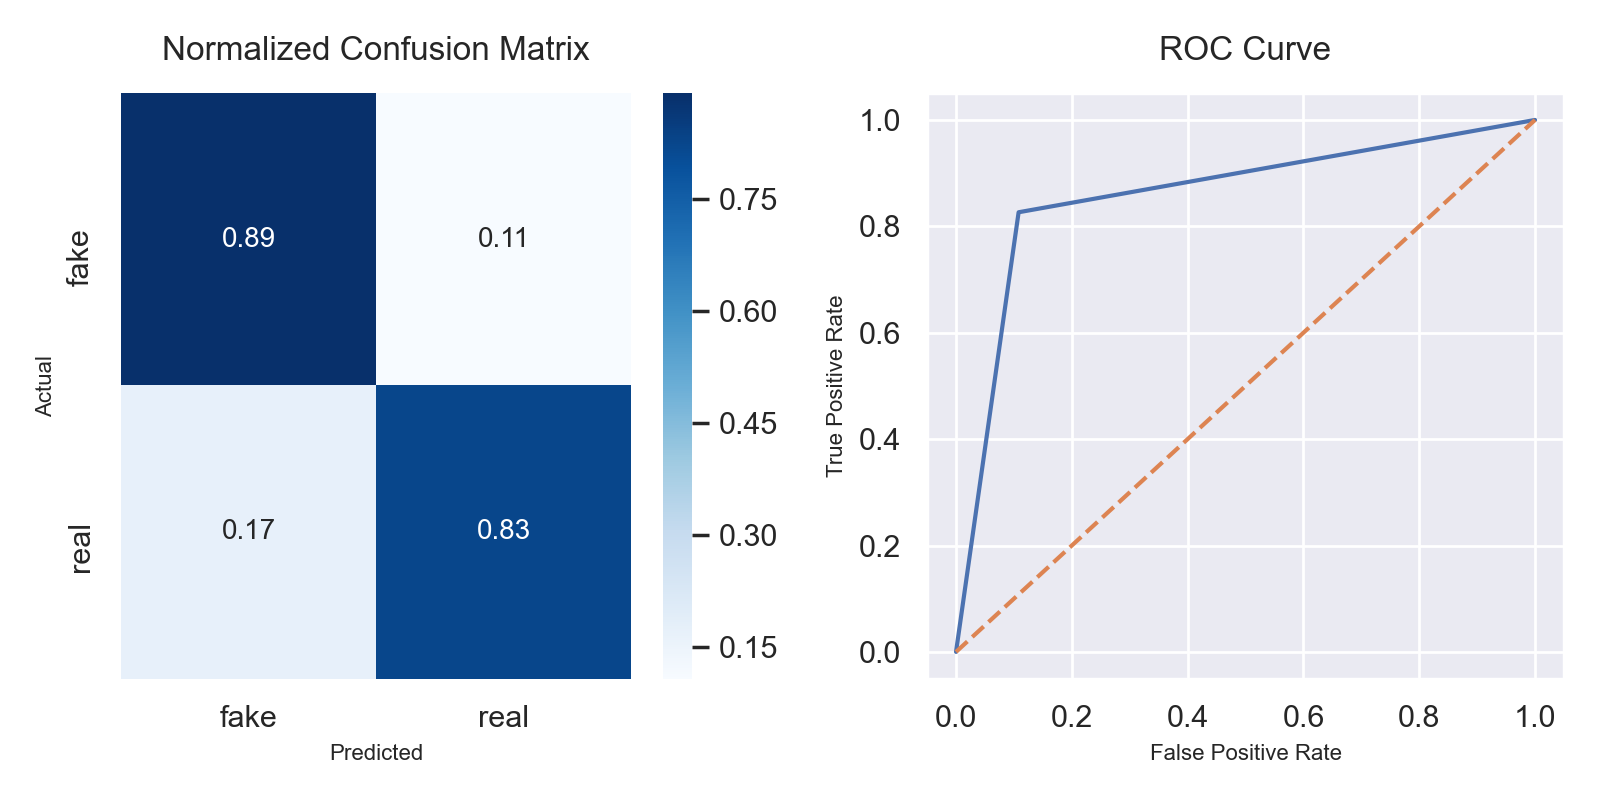

In [85]:
# test metric xgb
test_metrics(xgb_covid, tfidf_test_covid, testY_covid, labels)

In [86]:
# roc - xgb
xgb_covid_preds_test = xgb_covid.predict(tfidf_test_covid)
metrics.roc_auc_score(xgb_covid_preds_test,testY_covid)

0.8589285714285714

### Disasters
This dataset contains tweets about disasters around the world including natural disasters, terrorist attacks, etc. This topic is a wide variety of sub-categories so we will see if detection of real and fake is plausible.

In [87]:
natural.head()

Unnamed: 0                id title  \
1341        1341  natural_disaster         
1342        1342  natural_disaster         
1343        1343  natural_disaster         
1344        1344  natural_disaster         
1345        1345  natural_disaster         

                                                   text source target  \
1341  Our Deeds are the Reason of this #earthquake M...          real   
1342             Forest fire near La Ronge Sask. Canada          real   
1343  All residents asked to 'shelter in place' are ...          real   
1344  13,000 people receive #wildfires evacuation or...          real   
1345  Just got sent this photo from Ruby #Alaska as ...          real   

                                             clean_text clean_title  \
1341               deed reason earthquake allah forgive               
1342                   forest near la ronge sask canada               
1343  resident asked shelter place notified officer ...               
1344  people receive wildfire evacuation order calif...               
1345  got sent photo ruby alaska smoke wildfire pour...               

      news_class                                      combined_text  
1341           1               deed reason earthquake allah forgive  
1342           1                   forest near la ronge sask canada  
1343           1  resident asked shelter place notified officer ...  
1344           1  people receive wildfire evacuation order calif...  
1345           1  got sent photo ruby alaska smoke wildfire pour...

<IPython.core.display.Javascript object>


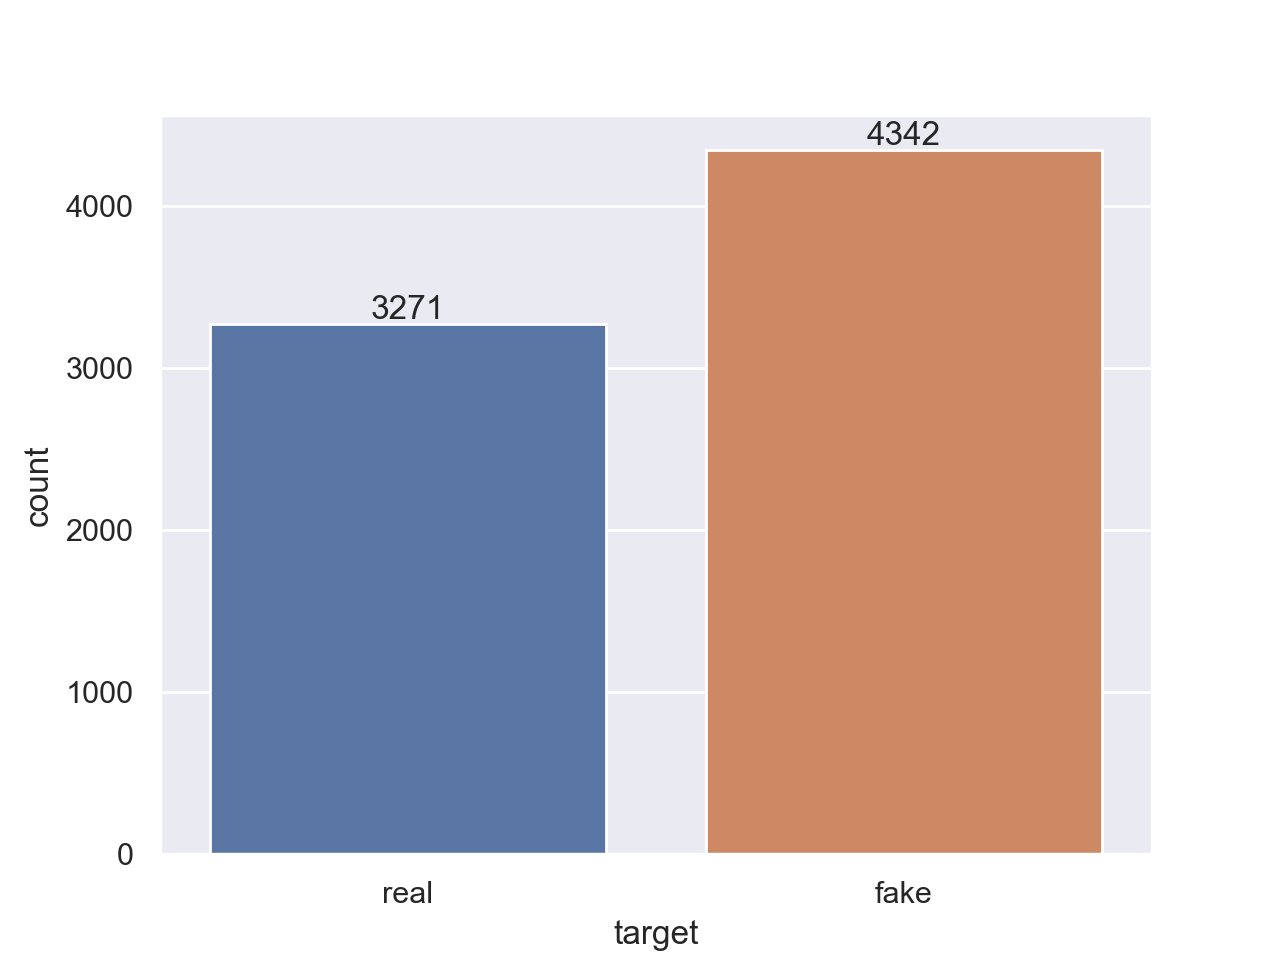

In [88]:
# check balance - make need to balance in modeling
ax=sns.countplot(x="target", data=natural)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

In [89]:
# balance data and run logistic, passive aggressive, Naive Bayes, rf, xgb
df_majority_nat = natural[natural.news_class==0]
df_minority_nat = natural[natural.news_class==1]

df_majority_downsampled_nat = resample(df_majority_nat, replace=False, n_samples=3300, random_state=123)

df_balance_nat = pd.concat([df_majority_downsampled_nat, df_minority_nat])
df_balance_nat['news_class'].value_counts()

0    3300
1    3271
Name: news_class, dtype: int64

In [90]:
# X and y data
X_nat, y_nat = df_balance_nat['combined_text'].values.astype('str'), df_balance_nat['news_class']
X_nat[0]

'ear started bleeding'

In [91]:
# train/test split
trainX_nat, testX_nat, trainY_nat, testY_nat = train_test_split(X_nat,y_nat, train_size=0.8, random_state=42, shuffle=True)

In [92]:
print(trainX_nat.shape)
print(testY_nat.shape)

(5256,)
(1315,)


#### Logistic Regression

In [93]:
# fit general logistic model
pipe_lr_nat = Pipeline([('tfidf', TfidfVectorizer()), 
                    ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr_nat, trainX_nat, trainY_nat)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2626
           1       0.94      0.87      0.90      2630

    accuracy                           0.91      5256
   macro avg       0.91      0.91      0.91      5256
weighted avg       0.91      0.91      0.91      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7758770390683507
Average CV Precision:  0.7770691477148837
Average CV Recall:  0.7758996921962702
Average CV F1 Score:  0.7756390348132832


In [94]:
# logistic regression - tune
lr_params_nat = {'tfidf__max_df': (0.70, 0.80, 0.90),
             'lr__penalty': ('l1','l2')}

lr_search_nat = RandomizedSearchCV(pipe_lr_nat, param_distributions=lr_params_nat,
                                   cv=3, random_state=42, return_train_score=True)
lr_search_nat.fit(trainX_nat, trainY_nat)

print("Best Hyperparameters:",lr_search_nat.best_params_)
print("Best CV score is {}".format(lr_search_nat.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.7, 'lr__penalty': 'l2'}
Best CV score is 0.778158295281583


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       674
           1       0.83      0.78      0.80       641

    accuracy                           0.81      1315
   macro avg       0.81      0.81      0.81      1315
weighted avg       0.81      0.81      0.81      1315



<IPython.core.display.Javascript object>


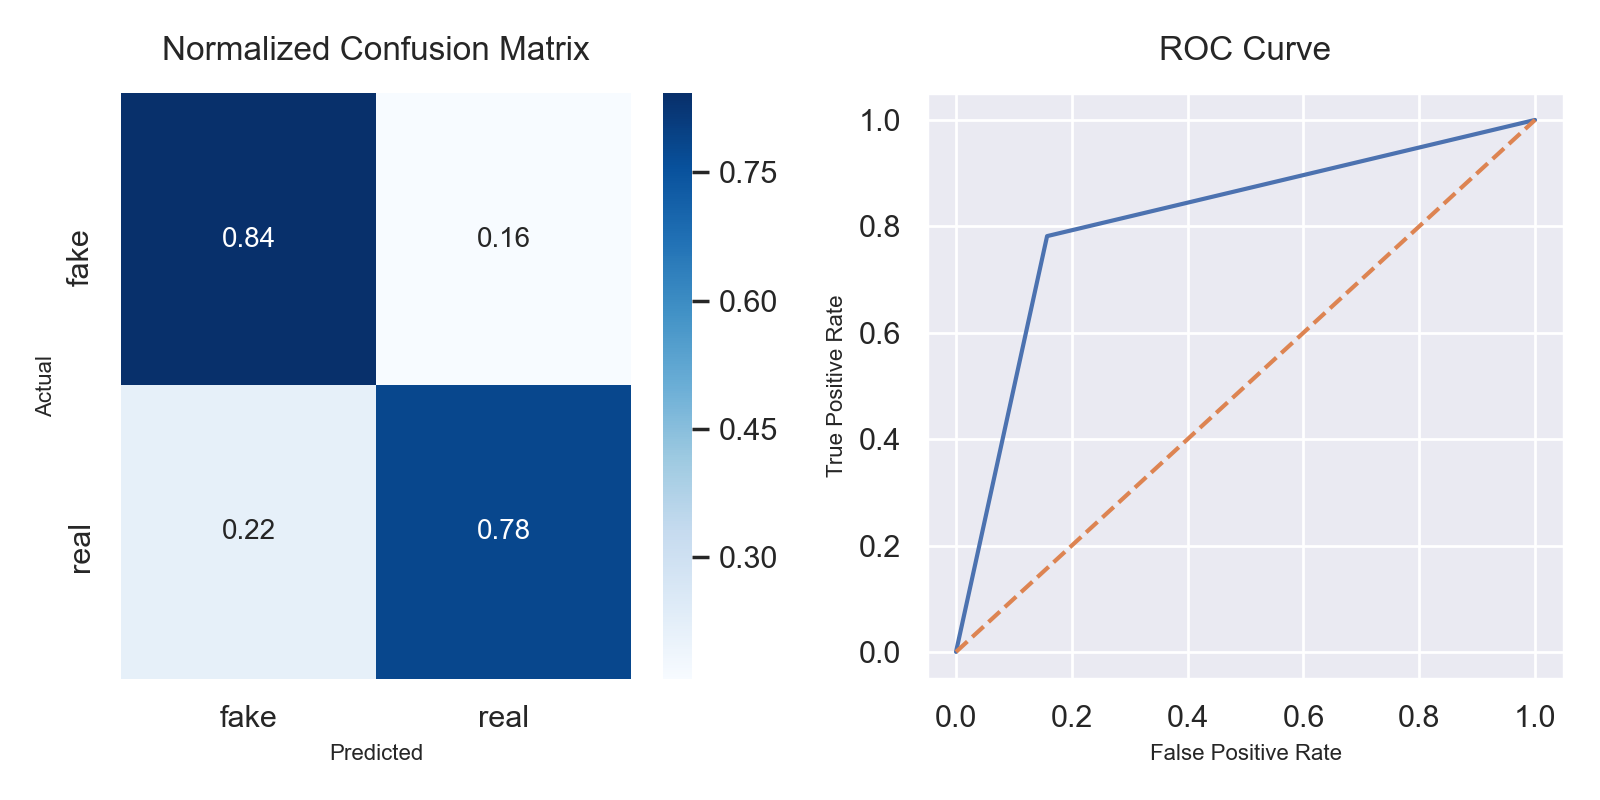

In [95]:
# test metrics logistitic regression
test_metrics(lr_search_nat.best_estimator_, testX_nat, testY_nat, labels)

In [96]:
# roc - lr
lr_nat_preds_test = lr_search_nat.best_estimator_.predict(testX_nat)
metrics.roc_auc_score(lr_nat_preds_test,testY_nat)

0.8138152812293487

In [97]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer_nat = TfidfVectorizer(max_df=0.7)
tfidf_train_nat = tfidf_vectorizer_nat.fit_transform(trainX_nat) 
tfidf_test_nat = tfidf_vectorizer_nat.transform(testX_nat)

#### Naive Bayes

In [98]:
# naive bayes classifier (multinomial)
nb_nat = MultinomialNB()
fit_model(nb_nat, tfidf_train_nat, trainY_nat)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2626
           1       0.93      0.90      0.92      2630

    accuracy                           0.92      5256
   macro avg       0.92      0.92      0.92      5256
weighted avg       0.92      0.92      0.92      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.774927011392373
Average CV Precision:  0.7753234096896501
Average CV Recall:  0.7749310157523086
Average CV F1 Score:  0.7748493307213646


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       674
           1       0.79      0.80      0.80       641

    accuracy                           0.80      1315
   macro avg       0.80      0.80      0.80      1315
weighted avg       0.80      0.80      0.80      1315



<IPython.core.display.Javascript object>


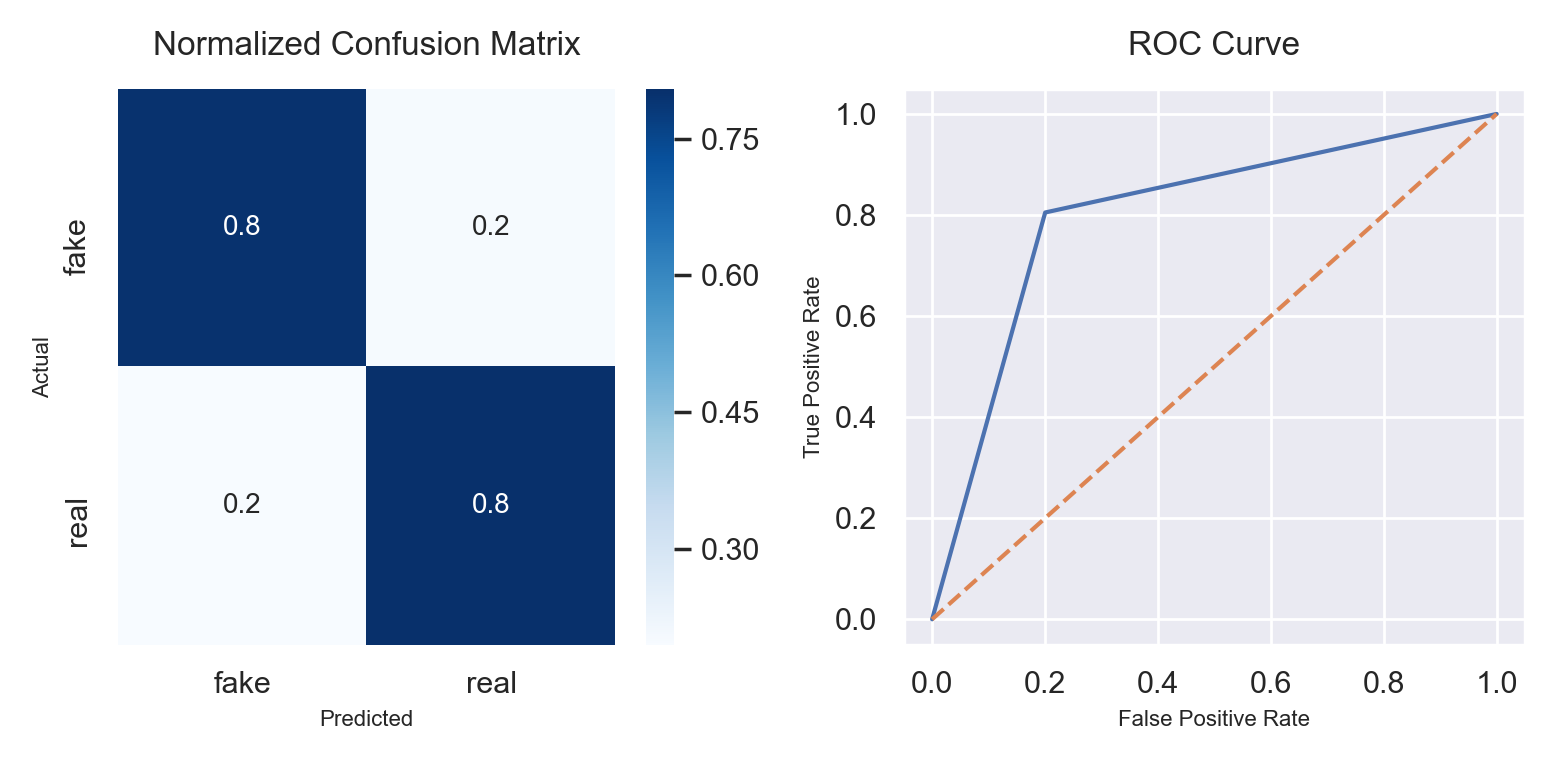

In [99]:
# NB - test metrics 
test_metrics(nb_nat, tfidf_test_nat, testY_nat, labels)

In [100]:
# roc - nb
nb_nat_preds_test = nb_nat.predict(tfidf_test_nat)
metrics.roc_auc_score(nb_nat_preds_test,testY_nat)

0.8021868580312032

#### Passive Agressive Classifier

In [101]:
# passive aggressive classifier 
pa_nat = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa_nat, tfidf_train_nat, trainY_nat)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2626
           1       0.99      0.98      0.99      2630

    accuracy                           0.99      5256
   macro avg       0.99      0.99      0.99      5256
weighted avg       0.99      0.99      0.99      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7382055113182087
Average CV Precision:  0.7389011313949894
Average CV Recall:  0.7382205323193917
Average CV F1 Score:  0.7380301931420694


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       674
           1       0.74      0.78      0.76       641

    accuracy                           0.76      1315
   macro avg       0.76      0.76      0.76      1315
weighted avg       0.76      0.76      0.76      1315



<IPython.core.display.Javascript object>


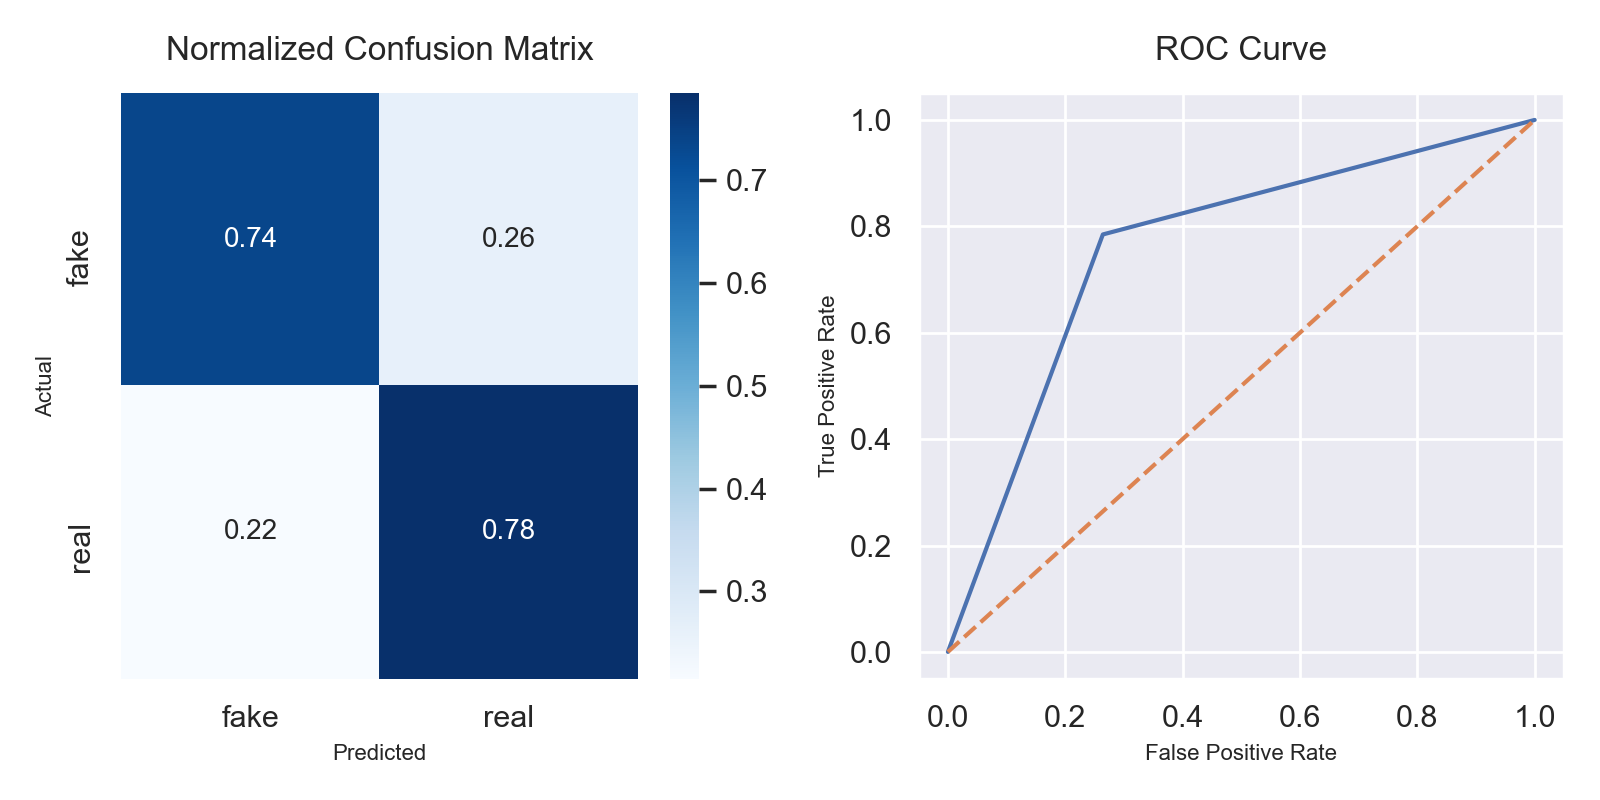

In [102]:
# PA - test metrics - disaster
test_metrics(pa_nat, tfidf_test_nat, testY_nat, labels)

In [103]:
# roc - pa
pa_nat_preds_test = pa_nat.predict(tfidf_test_nat)
metrics.roc_auc_score(pa_nat_preds_test,testY_nat)

0.7604770309018561

#### Random Forest

In [104]:
# random forest classifier 
rf_nat = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model(rf_nat, tfidf_train_nat, trainY_nat, 3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2626
           1       0.99      0.98      0.99      2630

    accuracy                           0.99      5256
   macro avg       0.99      0.99      0.99      5256
weighted avg       0.99      0.99      0.99      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7644605903733354
Average CV Precision:  0.7785028997245697
Average CV Recall:  0.7645411210557645
Average CV F1 Score:  0.7614548081599638


In [105]:
# RF - CV/tune took some time - so just test on larger n_estimators, 
rf_nat_500 = RandomForestClassifier(n_estimators=500, random_state=42)
rf_nat_500.fit(tfidf_train_nat, trainY_nat)
rf_nat_500_tr_preds = rf_nat_500.predict(tfidf_train_nat)
print('Training Metrics: ')
print(metrics.classification_report(trainY_nat, rf_nat_500_tr_preds))

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2626
           1       0.99      0.98      0.99      2630

    accuracy                           0.99      5256
   macro avg       0.99      0.99      0.99      5256
weighted avg       0.99      0.99      0.99      5256



Testing Metrics: 
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       674
           1       0.82      0.72      0.77       641

    accuracy                           0.79      1315
   macro avg       0.79      0.79      0.79      1315
weighted avg       0.79      0.79      0.79      1315



<IPython.core.display.Javascript object>


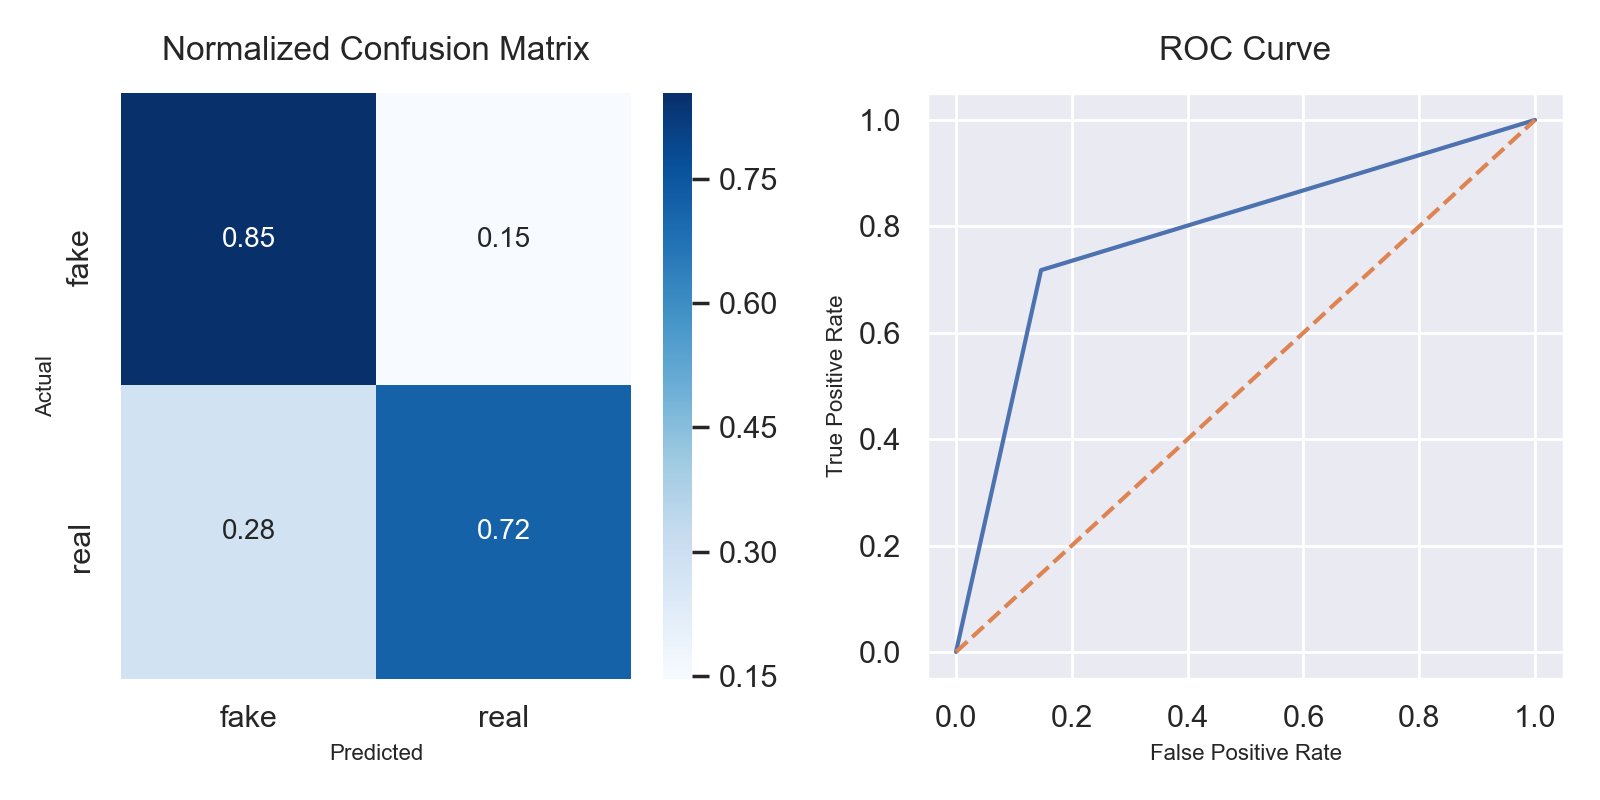

In [106]:
# test metrics RF_100
test_metrics(rf_nat, tfidf_test_nat, testY_nat, labels)

Testing Metrics: 
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       674
           1       0.83      0.72      0.77       641

    accuracy                           0.79      1315
   macro avg       0.80      0.79      0.79      1315
weighted avg       0.79      0.79      0.79      1315



<IPython.core.display.Javascript object>


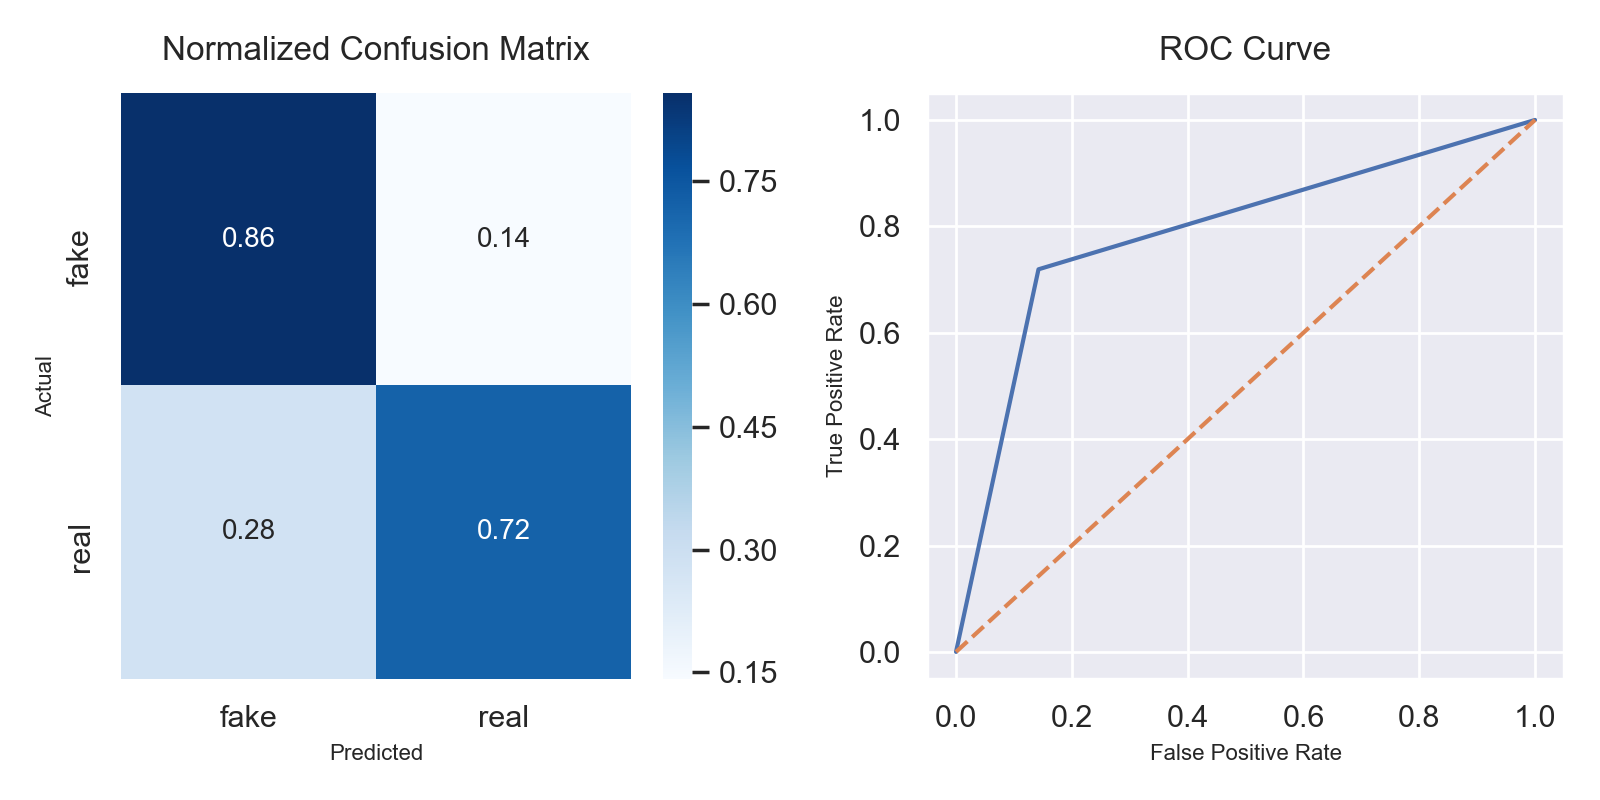

In [107]:
# test metrics RF_500 - not huge difference
test_metrics(rf_nat_500, tfidf_test_nat, testY_nat, labels)

In [110]:
# roc - rf_100
rf_nat_preds_test = rf_nat.predict(tfidf_test_nat)
metrics.roc_auc_score(rf_nat_preds_test,testY_nat)

0.7917400213911843

In [109]:
# roc - rf_500
rf_nat_500_preds_test = rf_nat_500.predict(tfidf_test_nat)
metrics.roc_auc_score(rf_nat_500_preds_test,testY_nat)

0.7950905482157999

#### Boosting
Gradient Boosting and XGBoost

In [111]:
# gradient boosting classifier 
gb_nat = GradientBoostingClassifier(random_state=42)
fit_model(gb_nat, tfidf_train_nat, trainY_nat,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      2626
           1       0.92      0.62      0.74      2630

    accuracy                           0.78      5256
   macro avg       0.82      0.78      0.78      5256
weighted avg       0.82      0.78      0.78      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7222242238576255
Average CV Precision:  0.7487535235703279
Average CV Recall:  0.7223444812131335
Average CV F1 Score:  0.7146330570674664


In [112]:
# xgb classifier 
xgb_nat = xgb.XGBClassifier(random_state=42)
fit_model(xgb_nat, tfidf_train_nat, trainY_nat,3)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.80      0.95      0.86      2626
           1       0.93      0.76      0.84      2630

    accuracy                           0.85      5256
   macro avg       0.86      0.85      0.85      5256
weighted avg       0.86      0.85      0.85      5256

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7553282778235041
Average CV Precision:  0.7629585111999647
Average CV Recall:  0.7553915347221137
Average CV F1 Score:  0.7535669374846851


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       674
           1       0.83      0.67      0.74       641

    accuracy                           0.77      1315
   macro avg       0.78      0.77      0.77      1315
weighted avg       0.78      0.77      0.77      1315



<IPython.core.display.Javascript object>


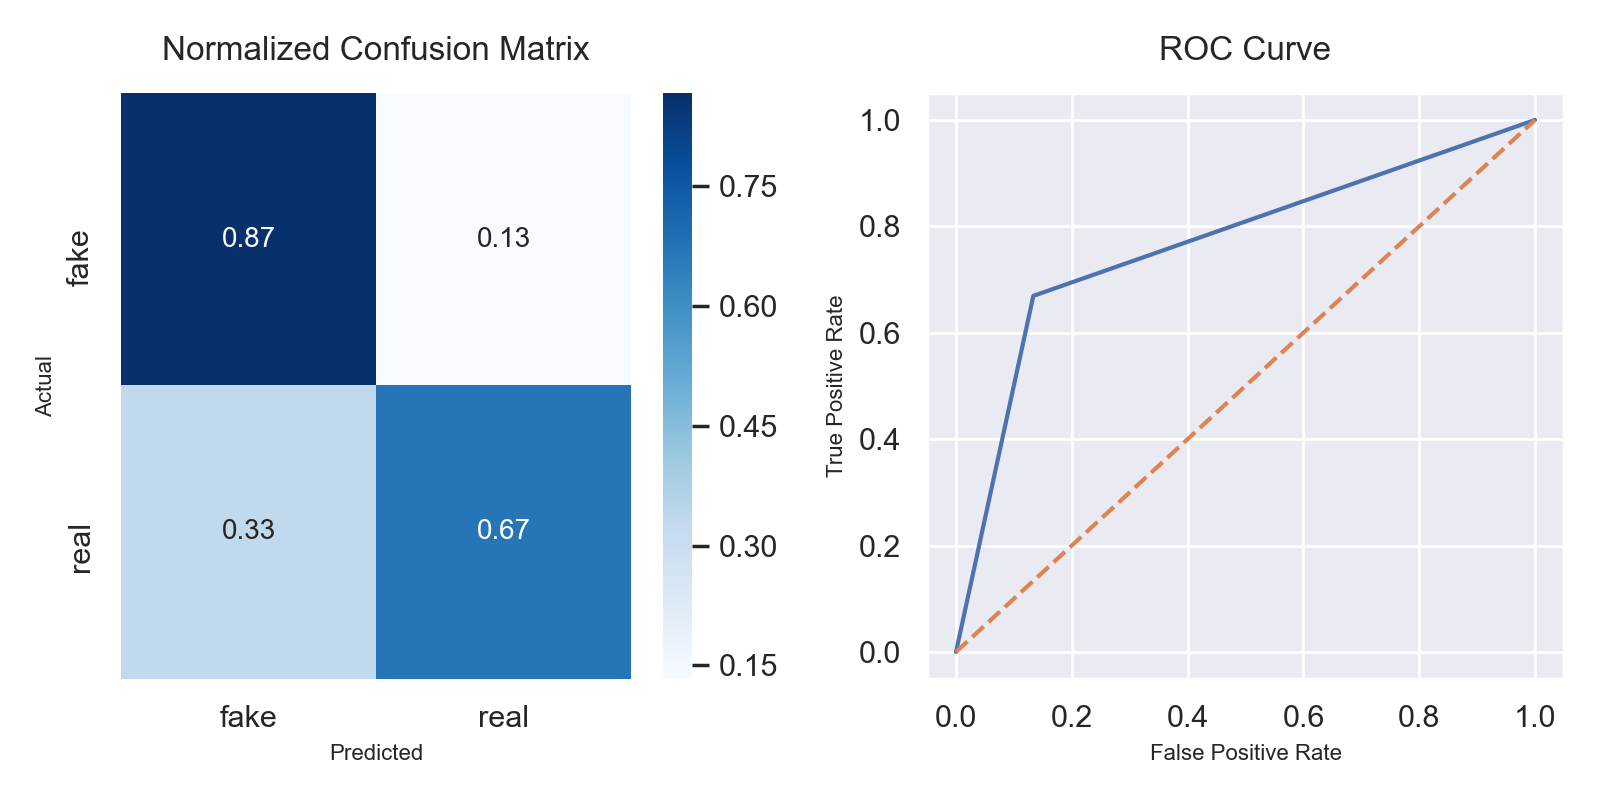

In [113]:
# test metric xgb
test_metrics(xgb_nat, tfidf_test_nat, testY_nat, labels)

In [114]:
# roc - xgb
xgb_nat_preds_test = xgb_nat.predict(tfidf_test_nat)
metrics.roc_auc_score(xgb_nat_preds_test,testY_nat)

0.7801289685421327